# convexHull & Convexity Defects를 활용한 Coronary 제거

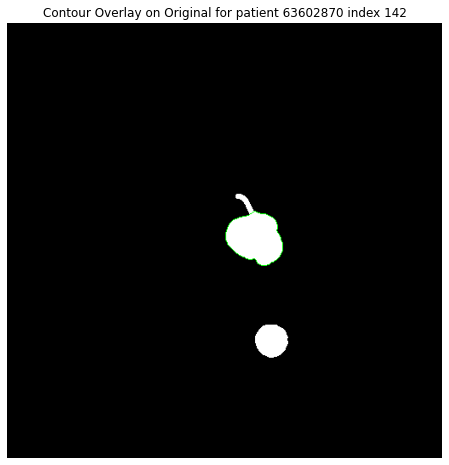

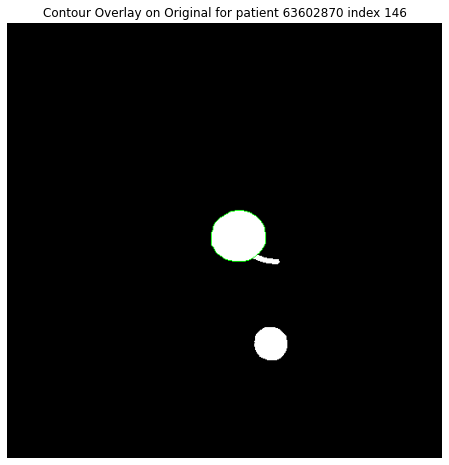

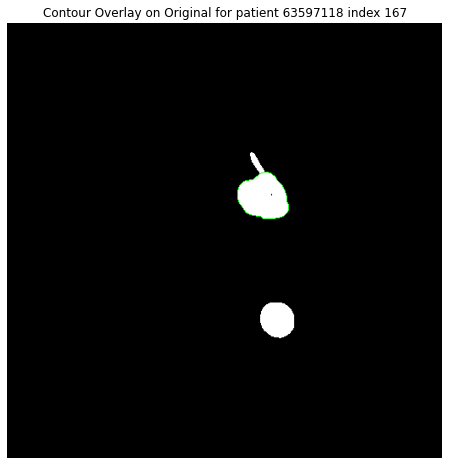

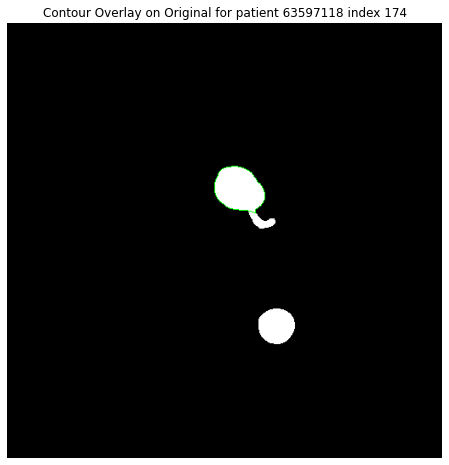

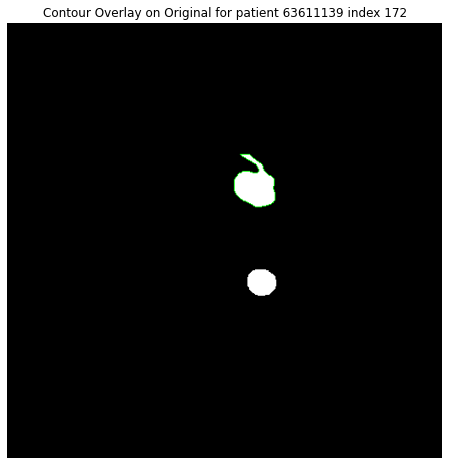

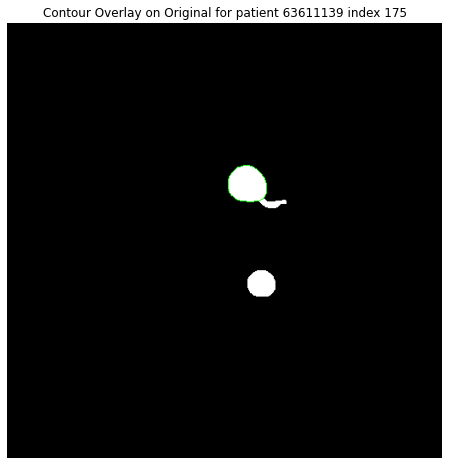

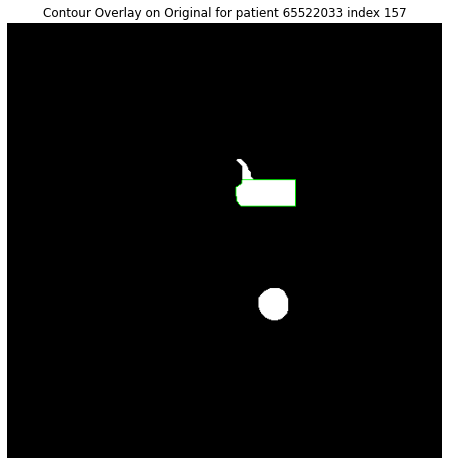

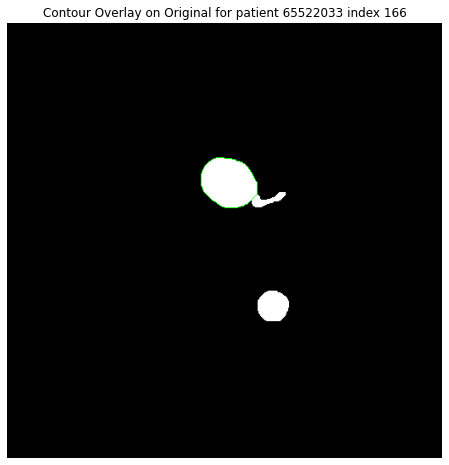

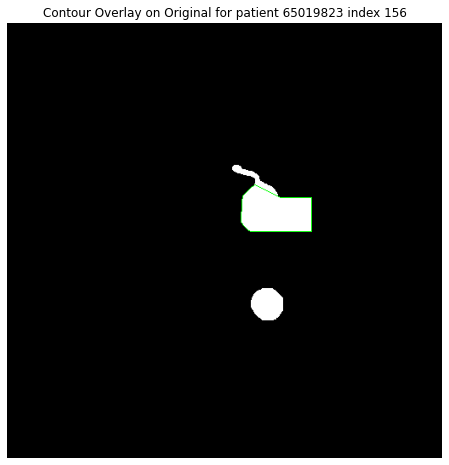

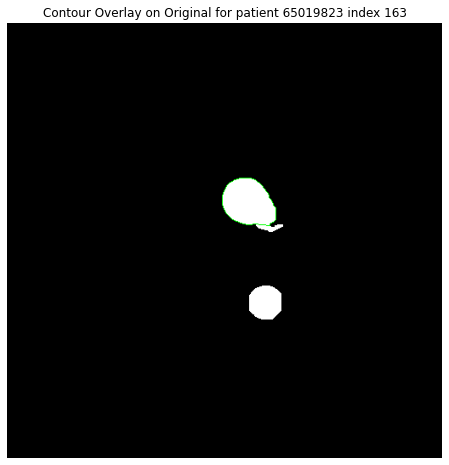

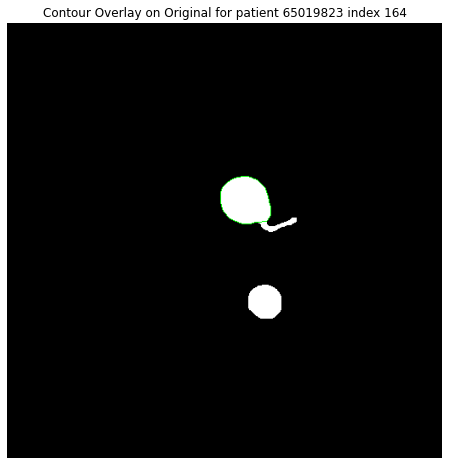

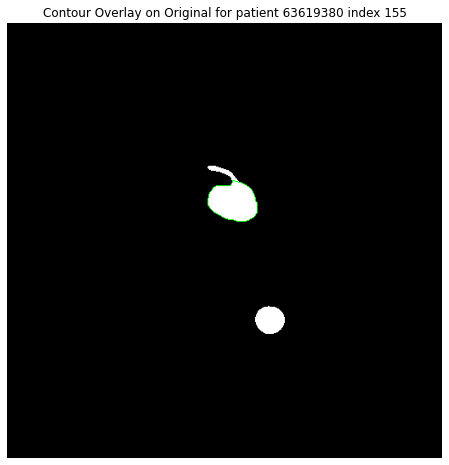

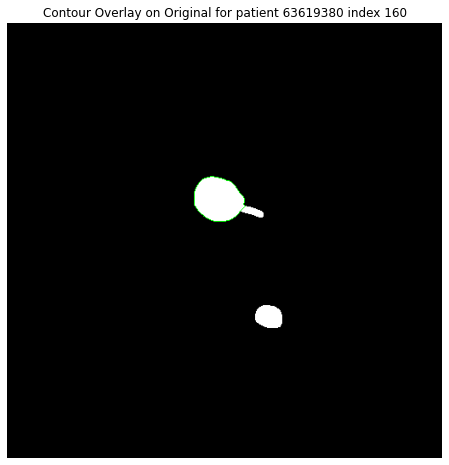

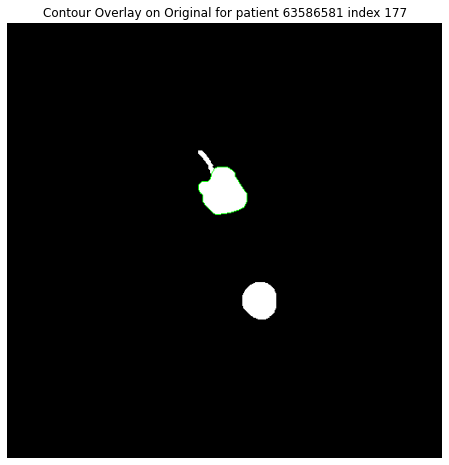

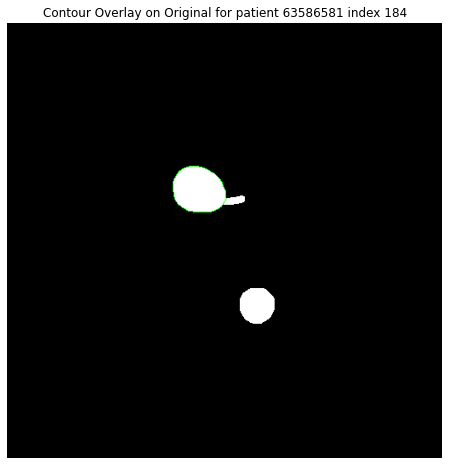

In [2]:
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2

# 유클리드 거리 제곱 계산 함수
def ed2(lhs, rhs):
    return(lhs[0] - rhs[0])**2 + (lhs[1] - rhs[1])**2

# 컨투어에서 디펙트 제거 함수
def remove_from_contour(contour, defectsIdx):
    minDist = np.inf
    startIdx, endIdx = 0, 0

    for i in range(len(defectsIdx)):
        for j in range(i+1, len(defectsIdx)):
            dist = ed2(contour[defectsIdx[i]][0], contour[defectsIdx[j]][0])
            if minDist > dist:
                minDist = dist
                startIdx = defectsIdx[i]
                endIdx = defectsIdx[j]

    if startIdx <= endIdx:
        inside = contour[startIdx:endIdx]
        len1 = 0 if inside.size == 0 else cv2.arcLength(inside, False)
        outside1 = contour[0:startIdx]
        outside2 = contour[endIdx:len(contour)]
        len2 = (0 if outside1.size == 0 else cv2.arcLength(outside1, False)) + (0 if outside2.size == 0 else cv2.arcLength(outside2, False))
        if len2 < len1:
            startIdx, endIdx = endIdx, startIdx
    else:
        inside = contour[endIdx:startIdx]
        len1 = 0 if inside.size == 0 else cv2.arcLength(inside, False)
        outside1 = contour[0:endIdx]
        outside2 = contour[startIdx:len(contour)]
        len2 = (0 if outside1.size == 0 else cv2.arcLength(outside1, False)) + (0 if outside2.size == 0 else cv2.arcLength(outside2, False))
        if len1 < len2:
            startIdx, endIdx = endIdx, startIdx

    if startIdx <= endIdx:
        out = np.concatenate((contour[0:startIdx], contour[endIdx:len(contour)]), axis=0)
    else:
        out = contour[endIdx:startIdx]
    return out

# 돌출부를 제거하는 함수
def remove_defects_from_mask(mask, depth_threshold=2, max_iterations=5):
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)

    for _ in range(max_iterations):
        # 컨투어 찾기
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        if len(contours) == 0:
            raise ValueError("No contours found")
        
        # 가장 큰 컨투어 선택
        contour = sorted(contours, key=cv2.contourArea)[-1]

        # 컨벡스 헐과 디펙트 계산
        hull = cv2.convexHull(contour, returnPoints=False)
        defects = cv2.convexityDefects(contour, hull)

        defectsIdx = []
        for i in range(defects.shape[0]):
            s, e, f, d = defects[i, 0]
            depth = d / 256
            if depth > depth_threshold:  # 임계값 이상 깊이의 디펙트 선택
                defectsIdx.append(f)

        if len(defectsIdx) < 2:
            break

        contour = remove_from_contour(contour, defectsIdx)

        # 컨투어로 마스크 갱신
        mask = np.zeros_like(mask)
        cv2.drawContours(mask, [contour], -1, 255, thickness=cv2.FILLED)

    return contour

# Patient to index mapping
patient_index_map = {
    '63602870': [142, 146],
    '63597118': [167, 174],
    '63611139': [172, 175],
    '65522033': [157, 166],
    '65019823': [156, 163, 164],
    '63619380': [155, 160],
    '63586581': [177, 184]
}

# 반복 처리
for patient, index_list in patient_index_map.items():
    label_path = f"/home/seokjun/nas199_kidney/Angiography/Angiography/2. CT/15. TAVI/DatasetForDL_2024/{patient}/label"
    
    for index in index_list:
        image_path = os.path.join(label_path, str(index) + ".png")
        
        # 이미지 열기
        img = Image.open(image_path)
        
        # 이미지 numpy 배열로 변환
        img_array = np.array(img)
        
        # 마스크 추출 (여기서는 흰색 픽셀을 마스크로 가정)
        mask = np.stack([img_array]*3, axis=-1)  # 3채널 이미지로 변환
        
        # 디펙트 제거 후 컨투어를 이용해 윤곽선 추출
        # 돌출부위
        contour = remove_defects_from_mask(mask, depth_threshold=3, max_iterations=50)  # max_iterations 추가
        
        # 원본 이미지 위에 윤곽선 그리기
        img_with_contour = img_array.copy()
        img_with_contour = cv2.cvtColor(img_with_contour, cv2.COLOR_GRAY2BGR)
        cv2.drawContours(img_with_contour, [contour], -1, (0, 255, 0), thickness=1)
        
        # 결과 시각화
        plt.figure(figsize=(8, 8))
        plt.imshow(img_with_contour)
        plt.title(f"Contour Overlay on Original for patient {patient} index {index}")
        plt.axis('off')
        plt.show()


# Convexity Defects + 중심점 방사형으로 제거
### 슬라이스 내의 모든 마스크에 적용_1

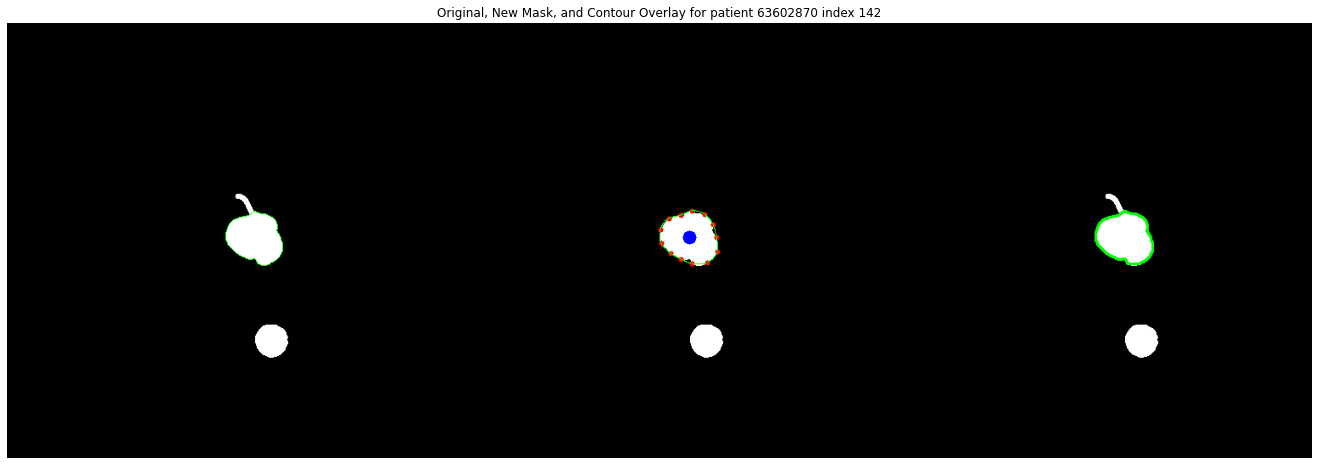

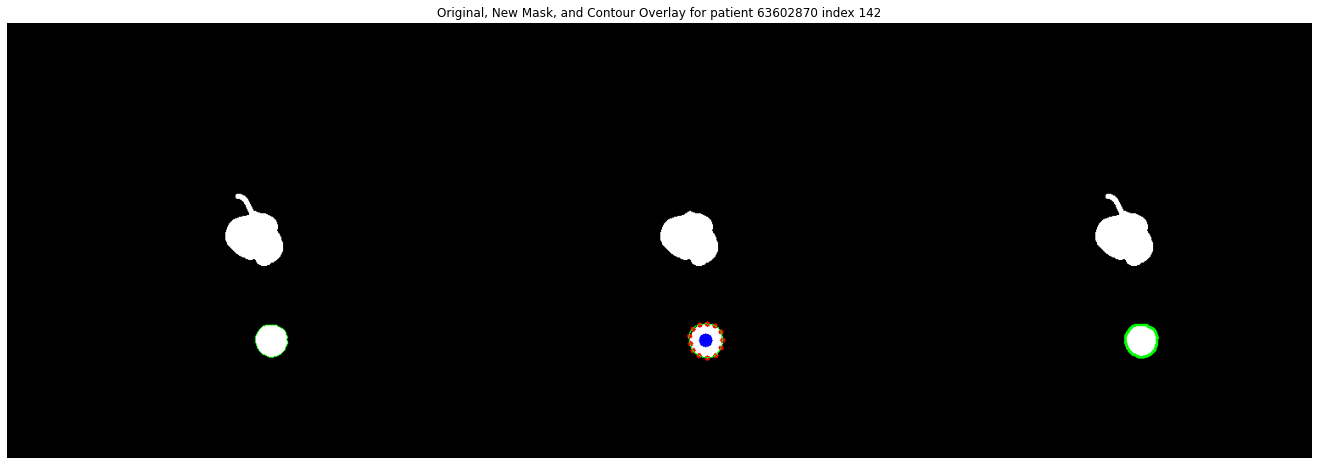

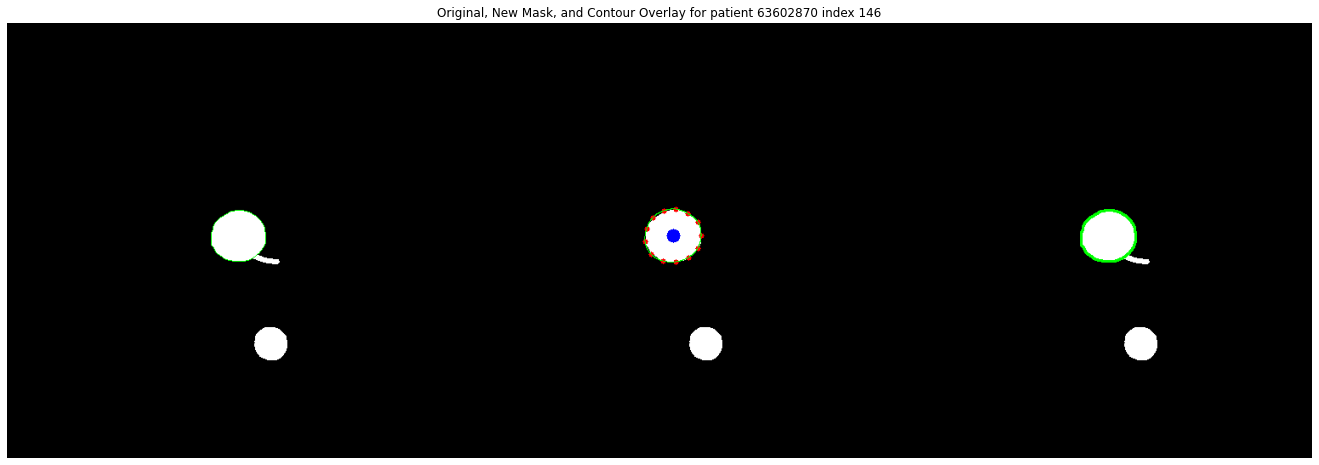

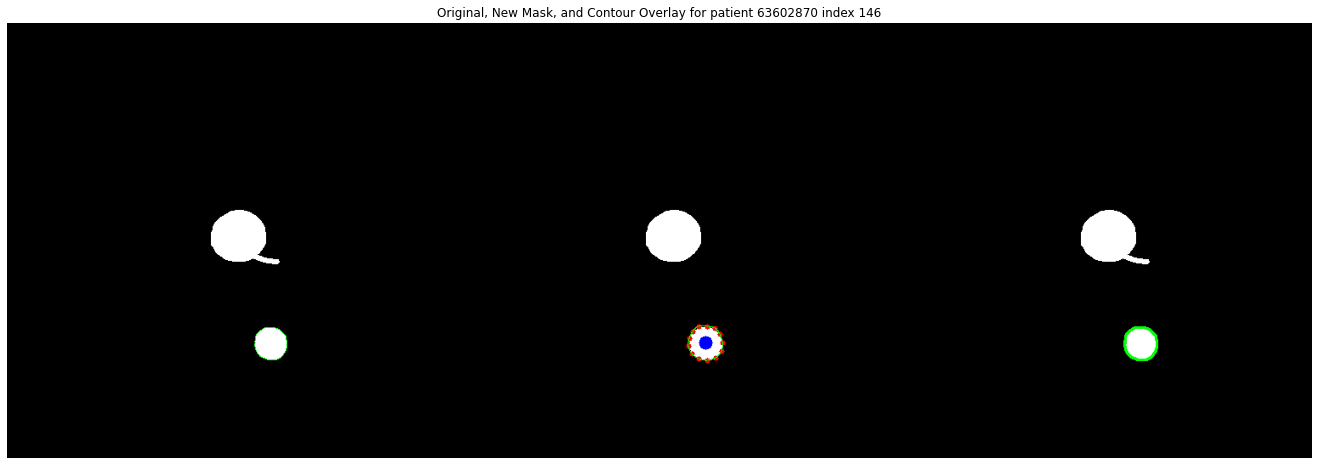

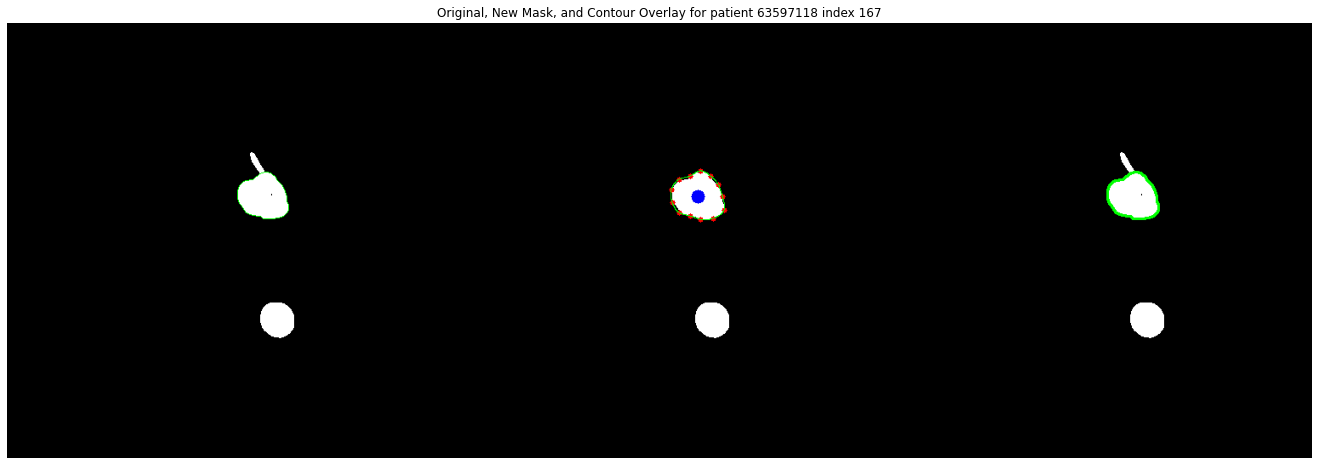

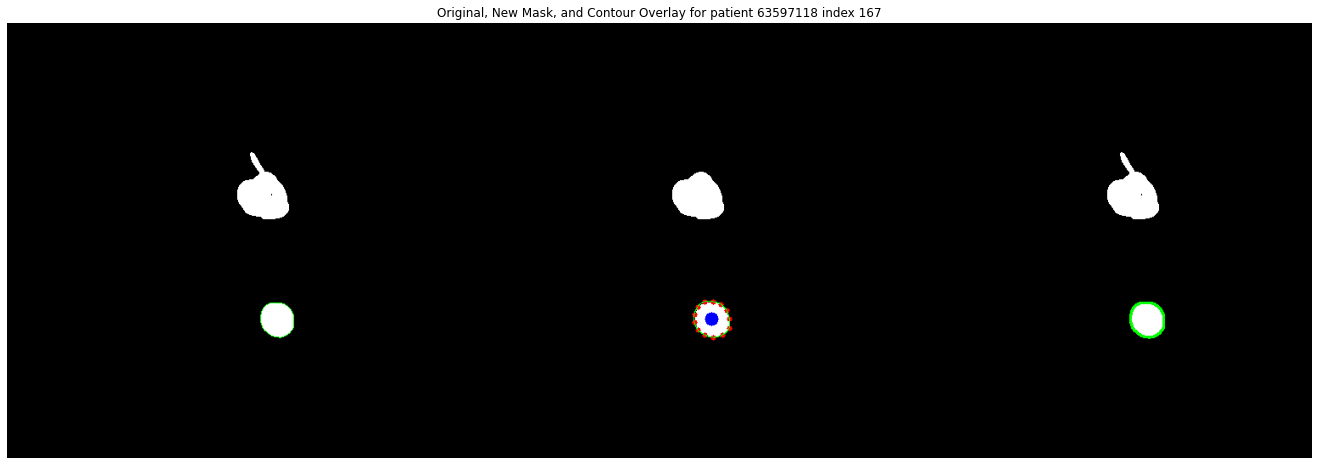

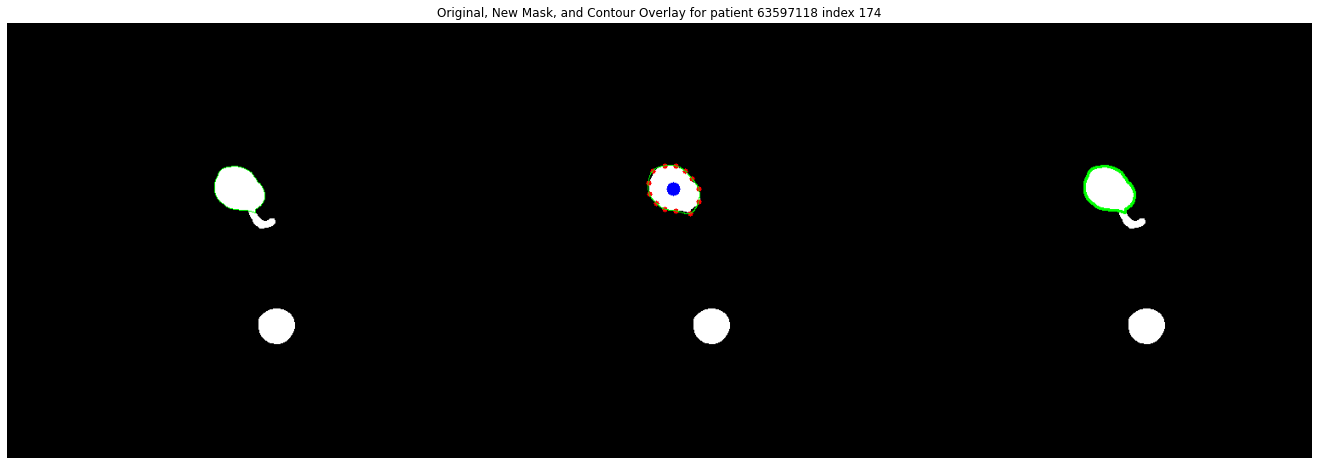

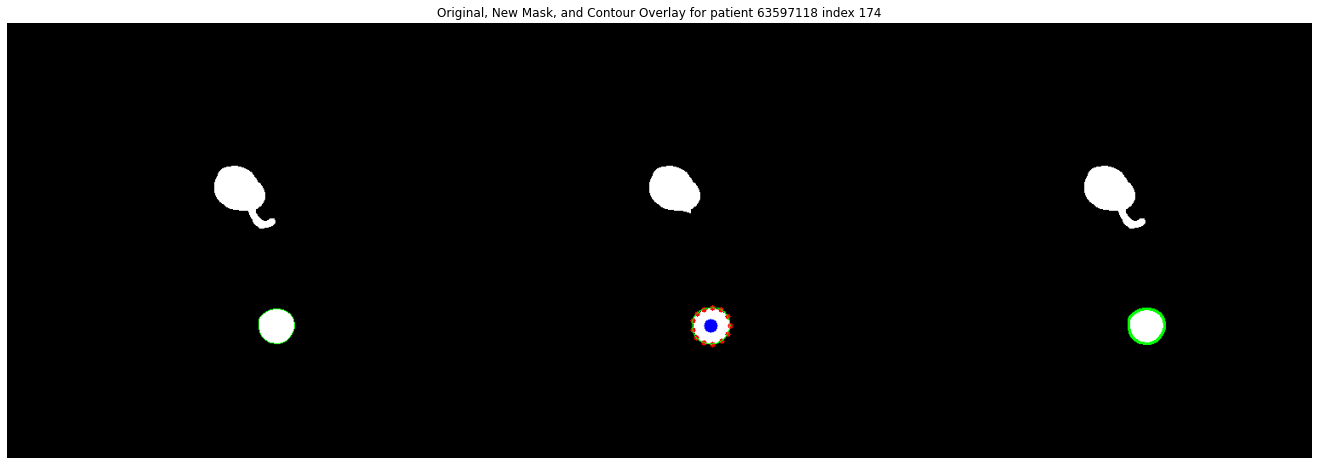

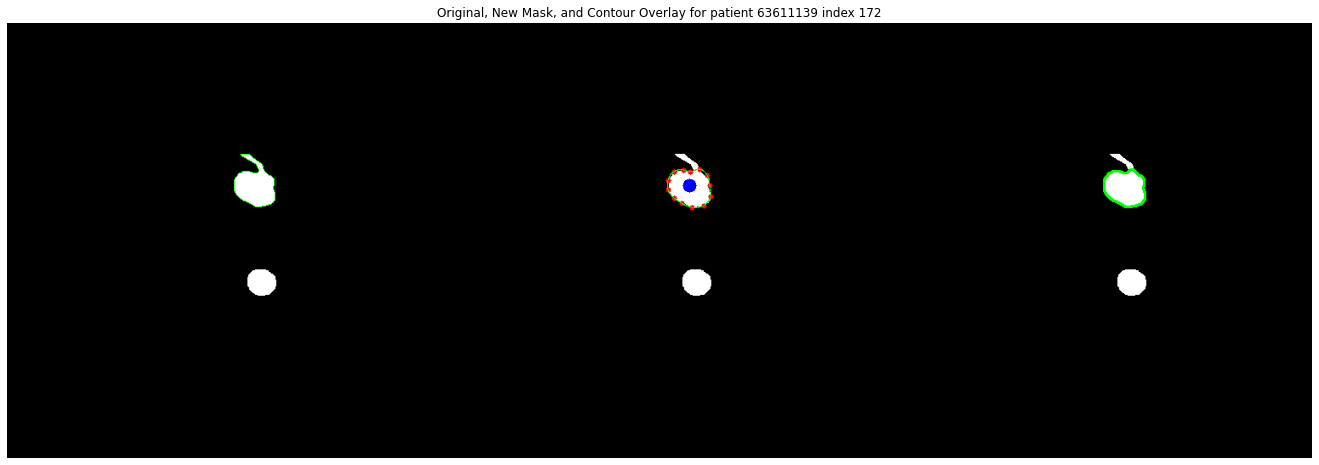

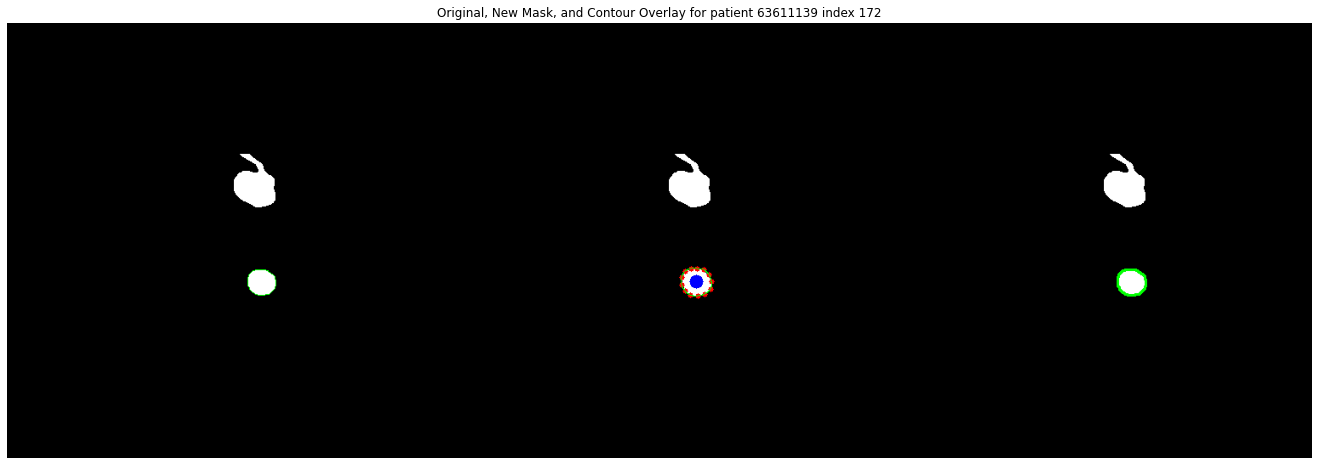

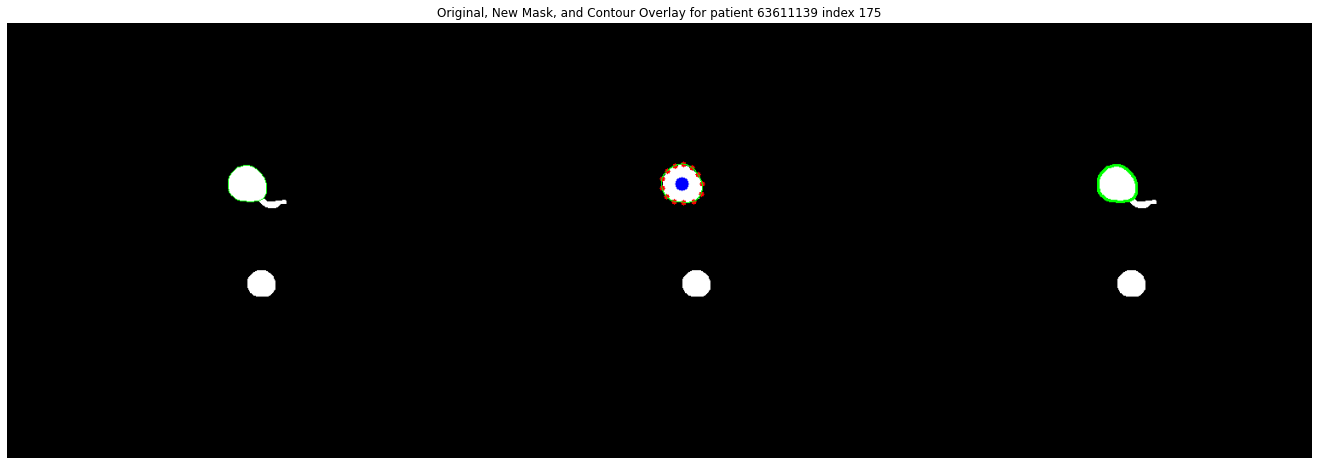

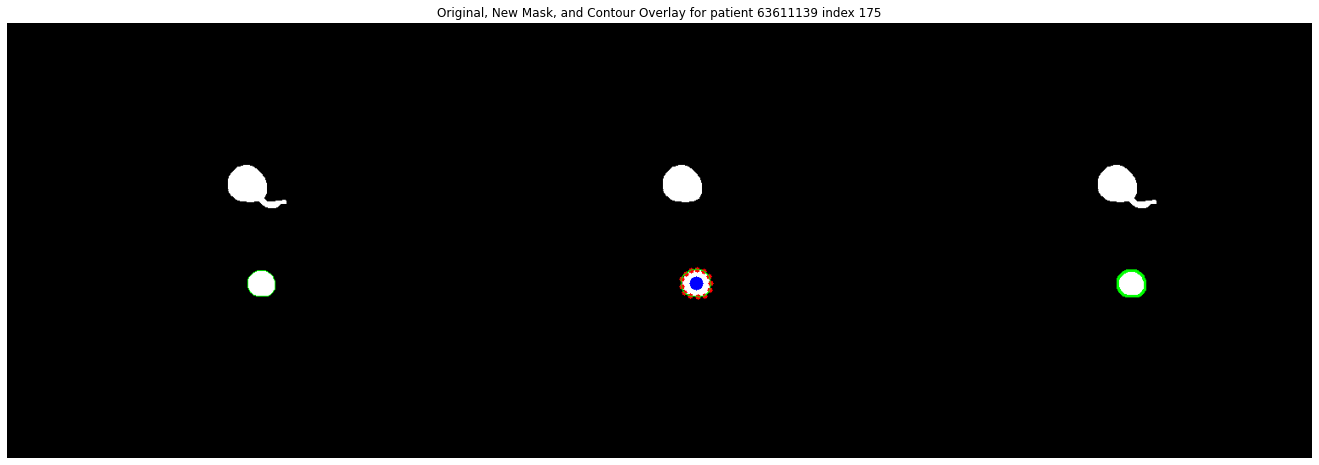

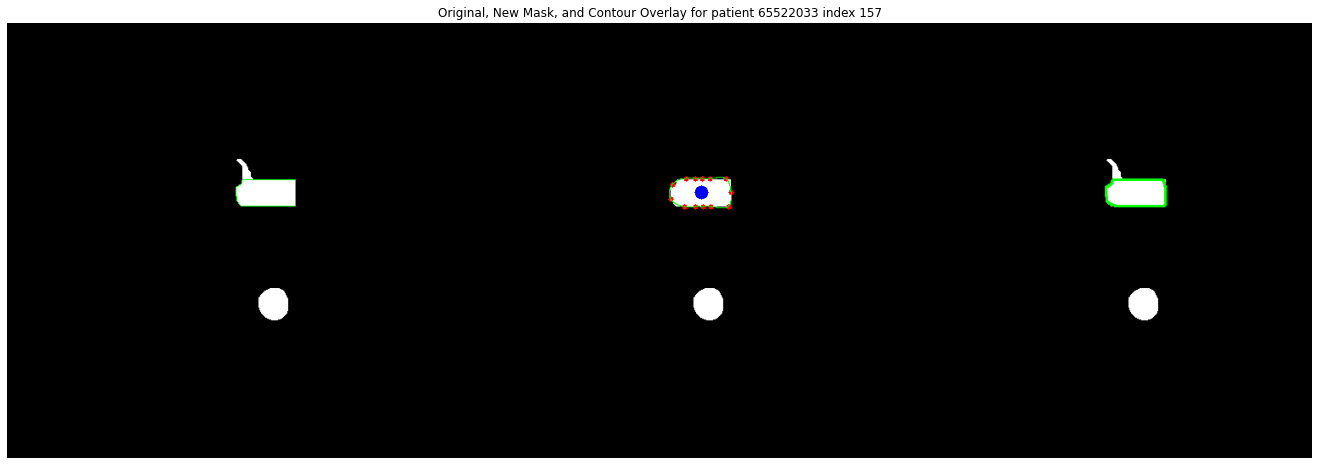

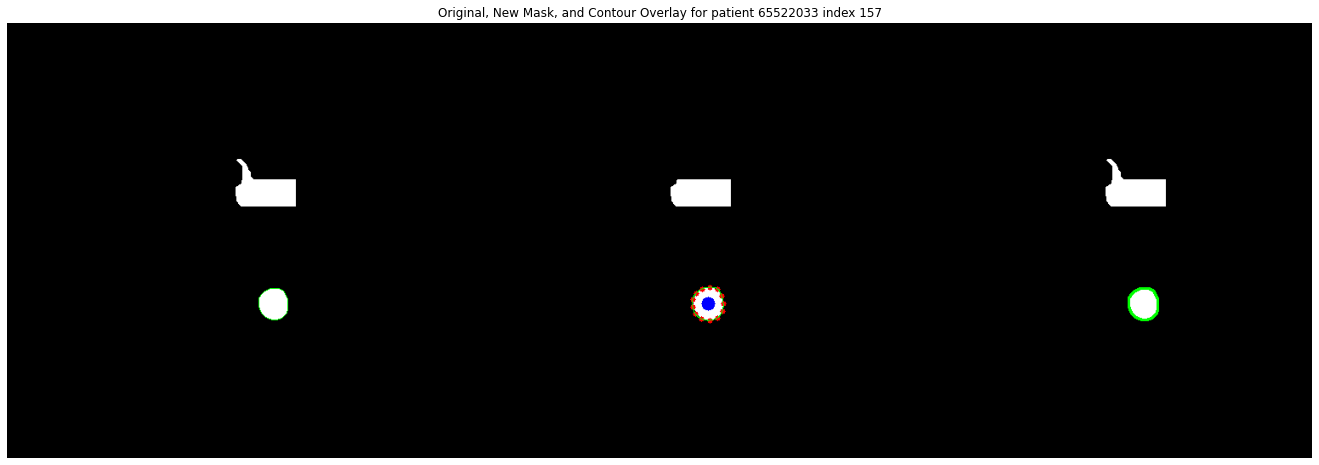

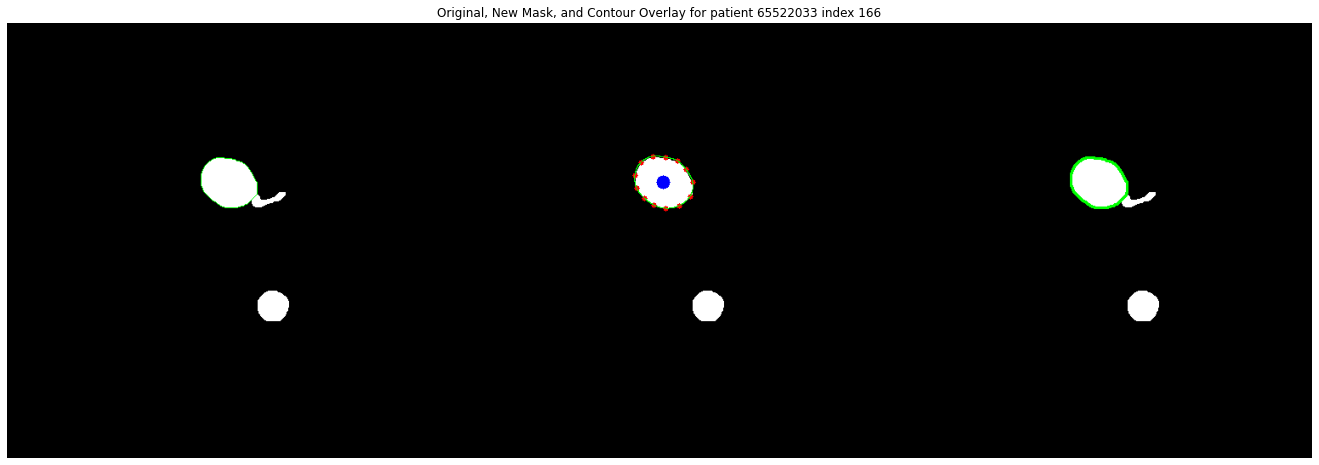

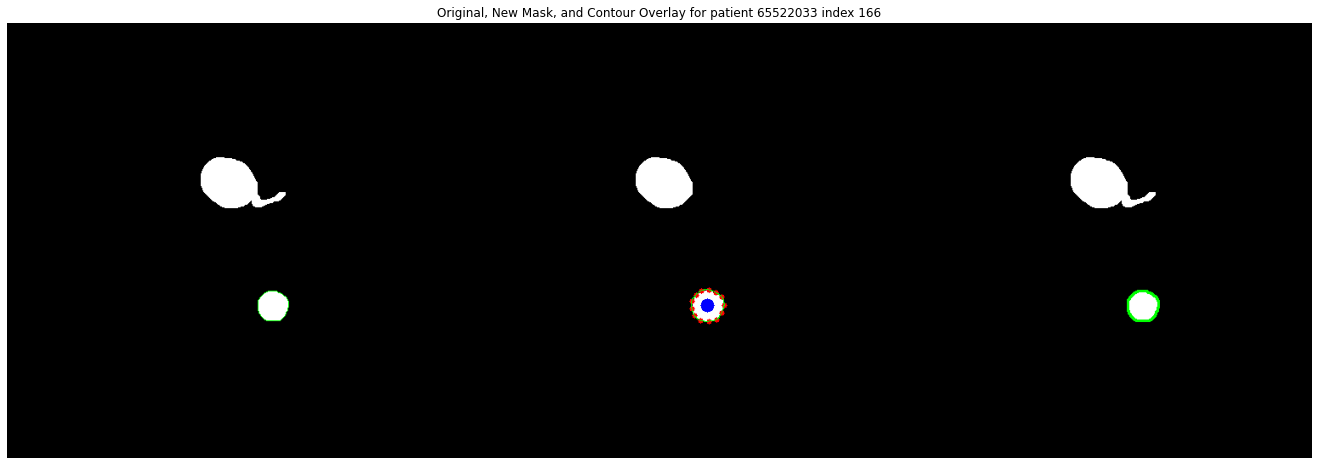

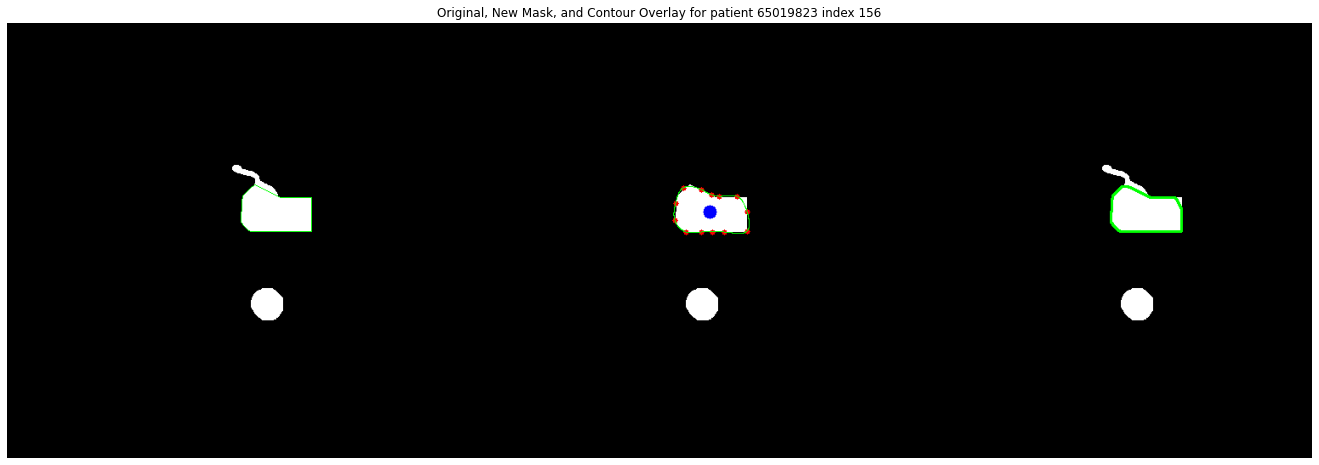

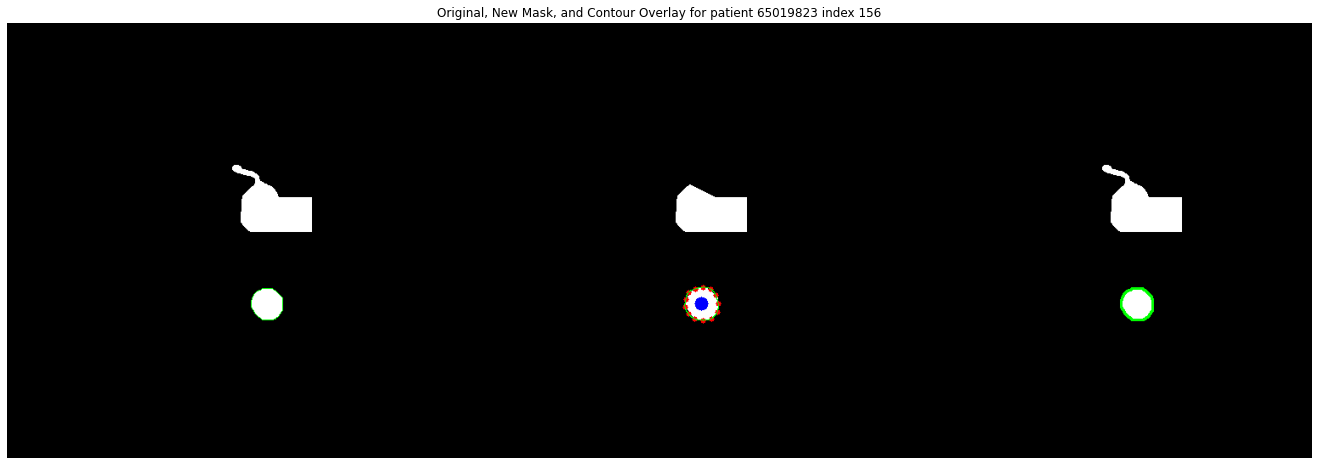

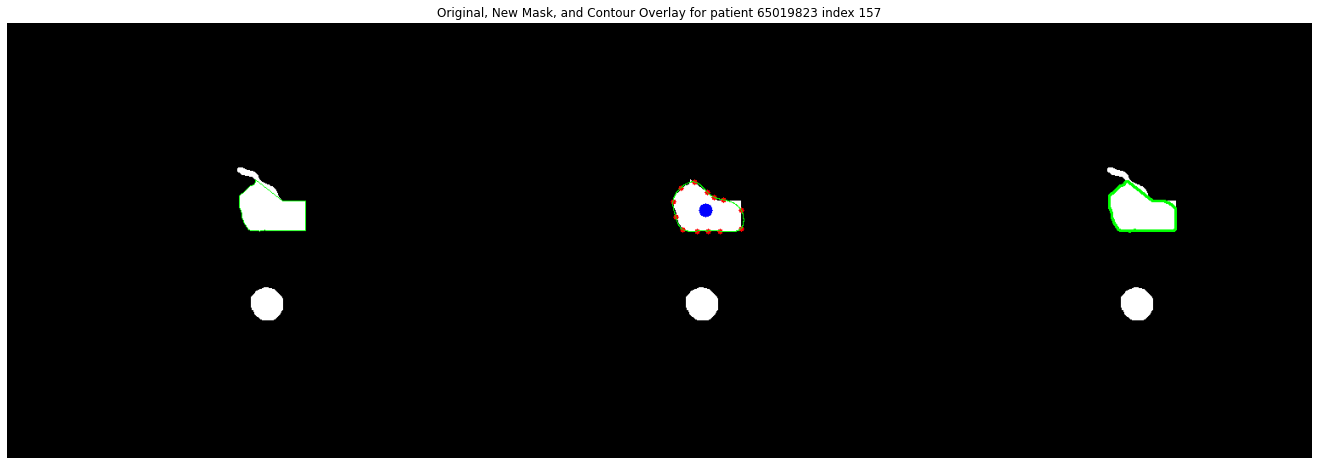

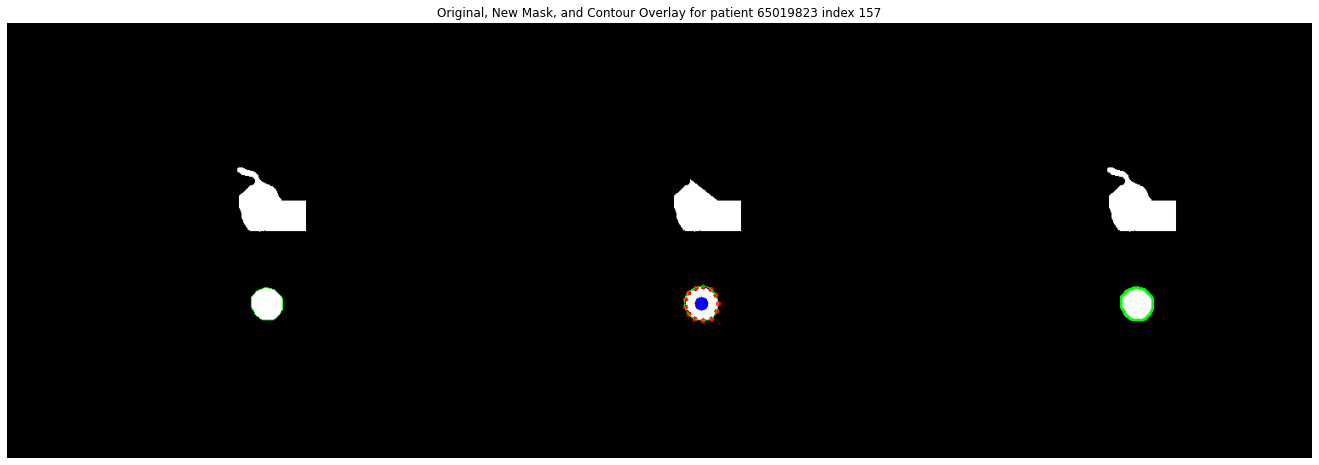

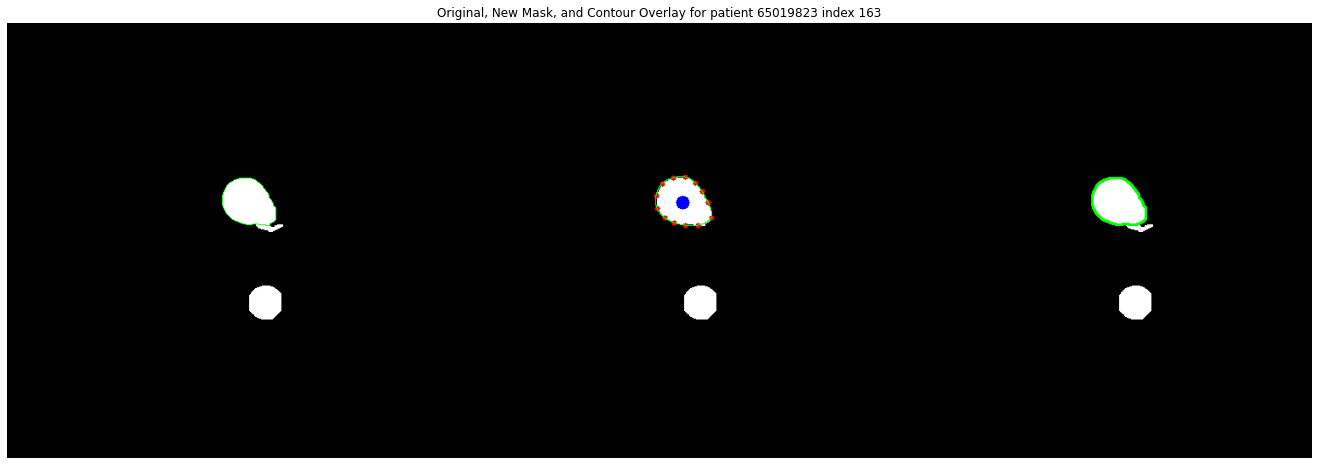

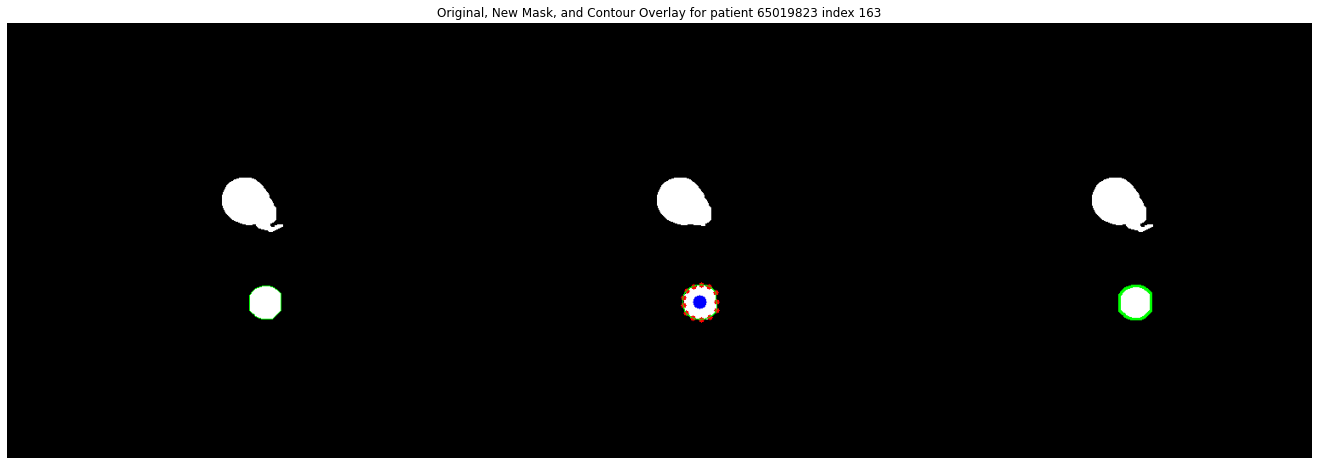

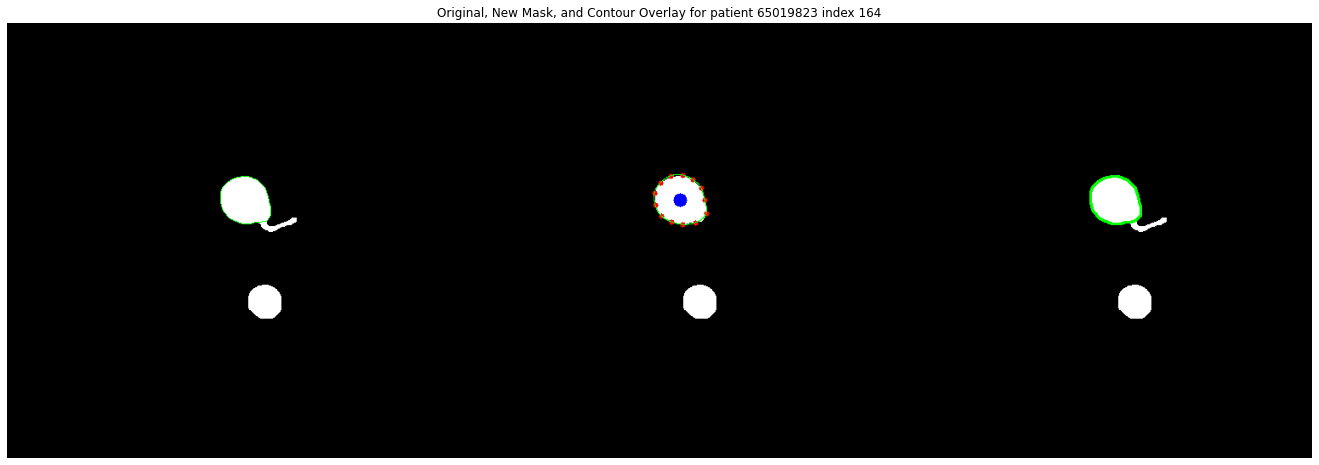

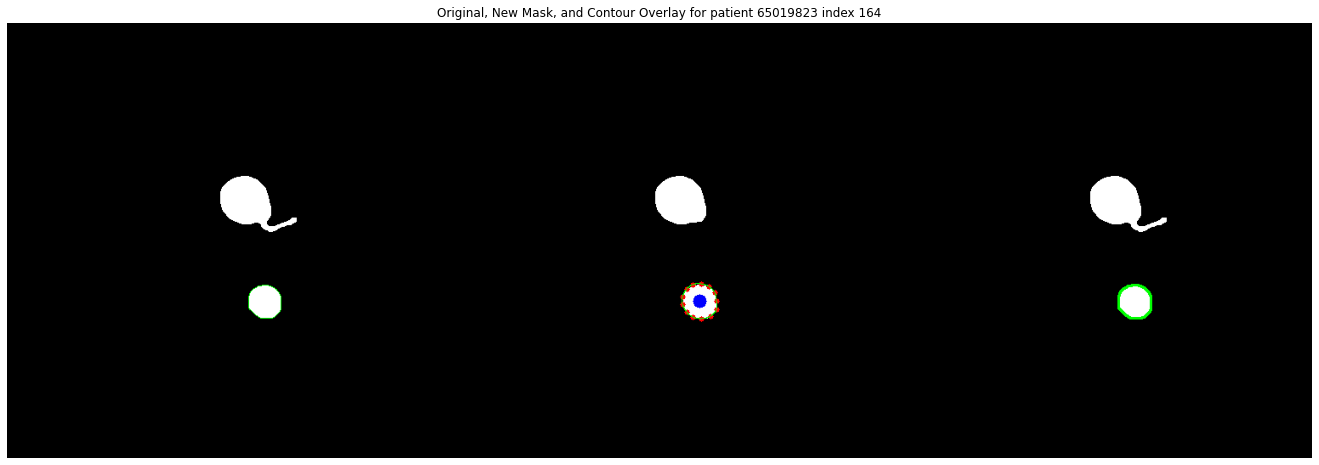

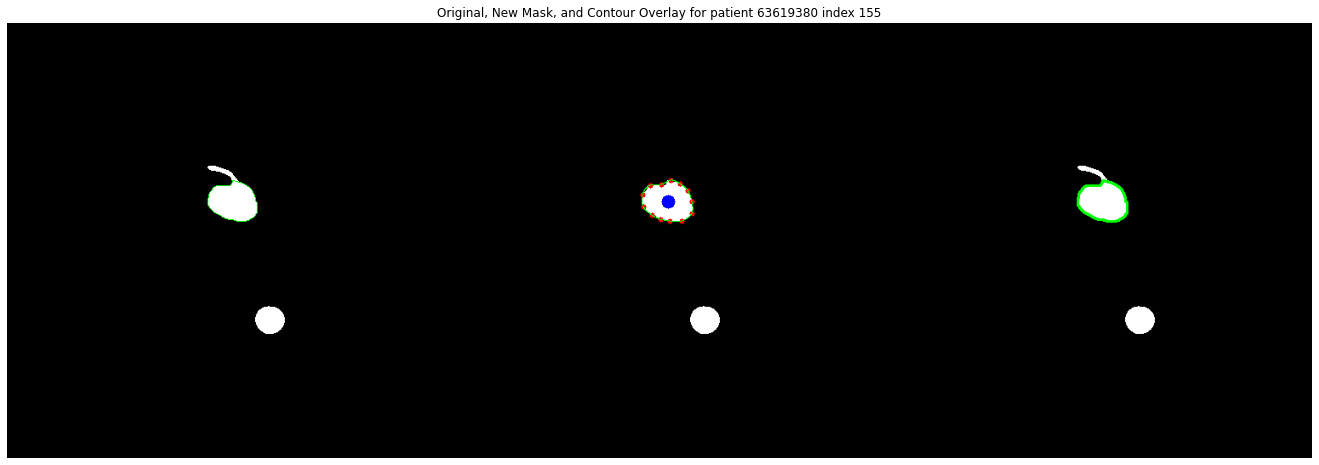

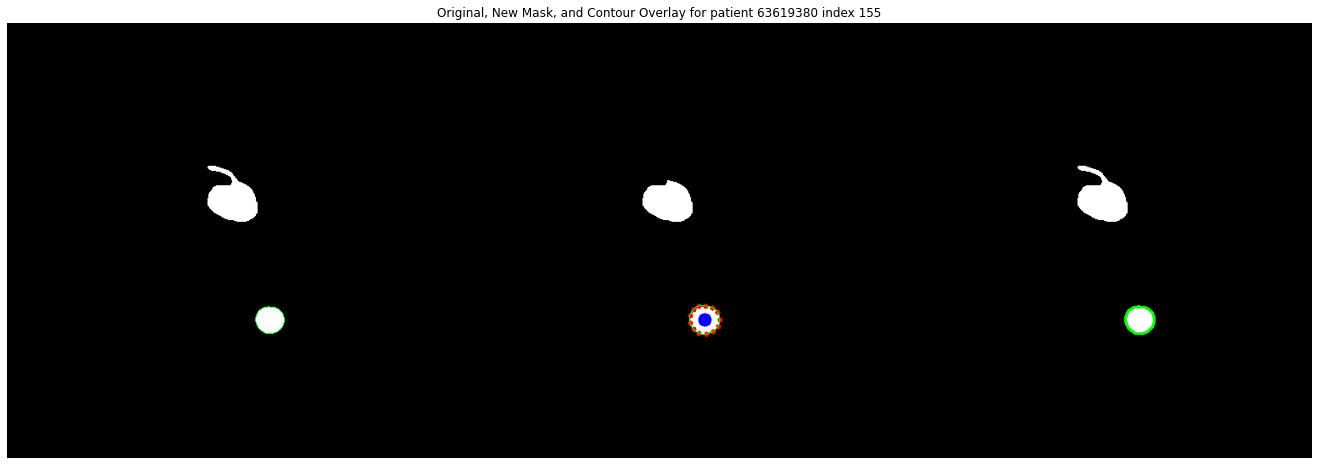

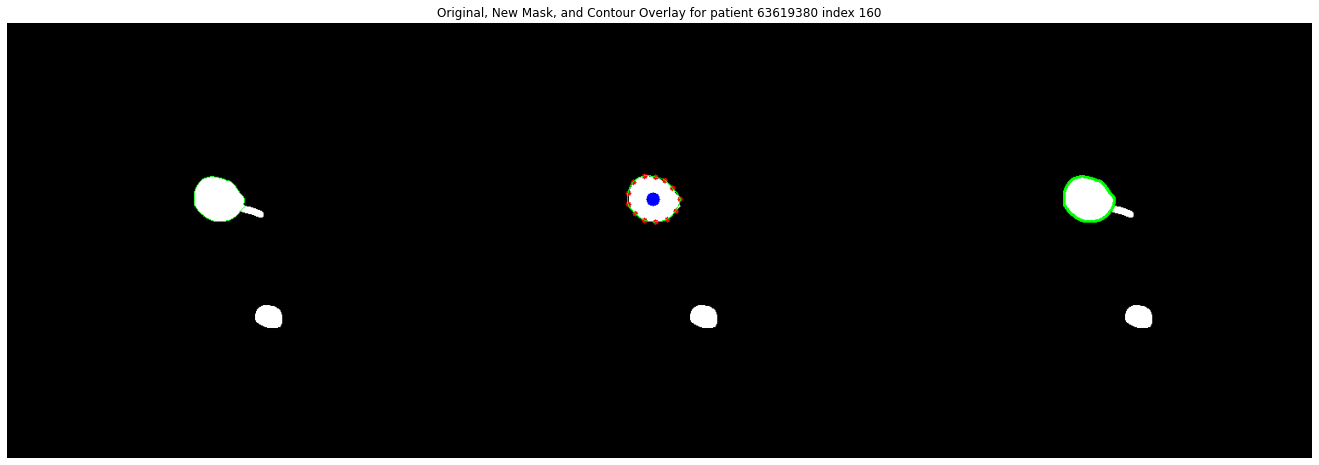

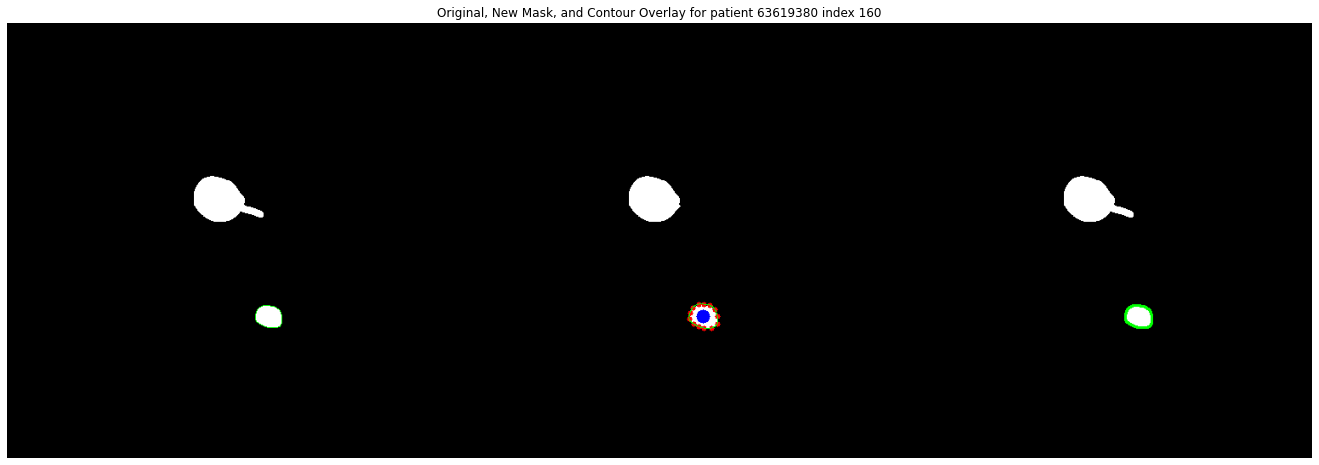

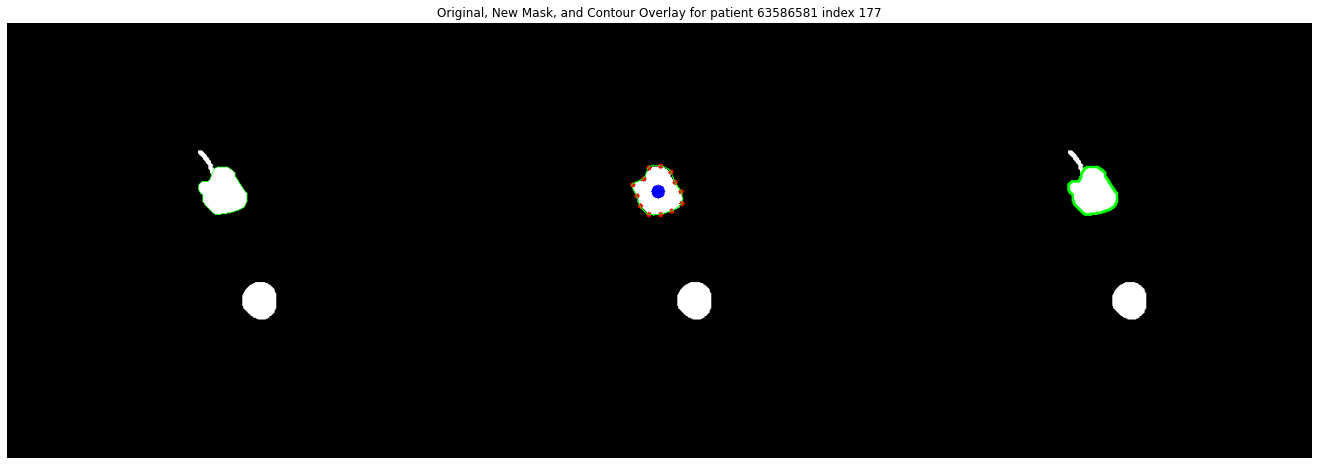

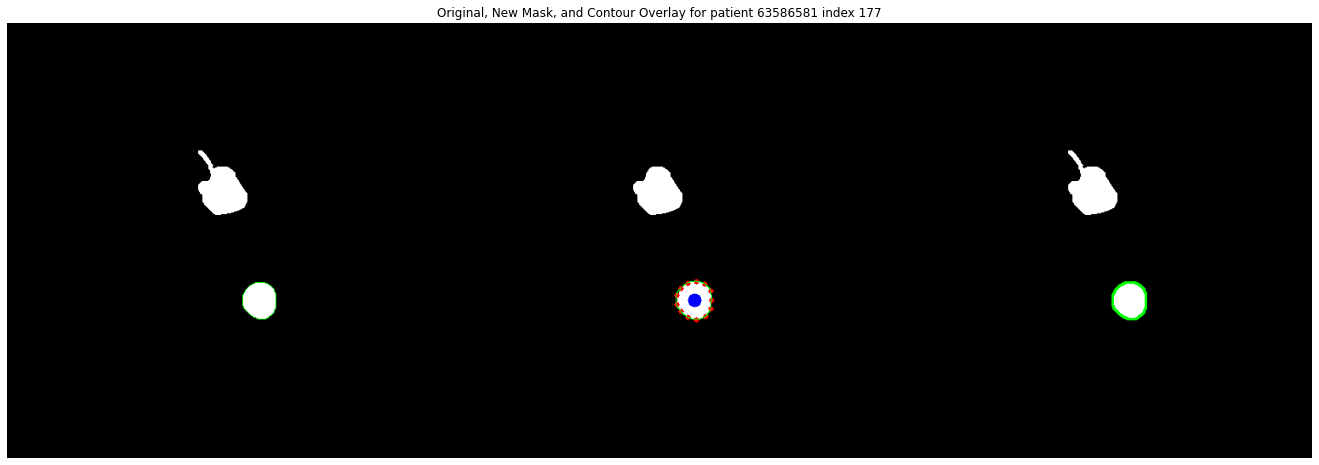

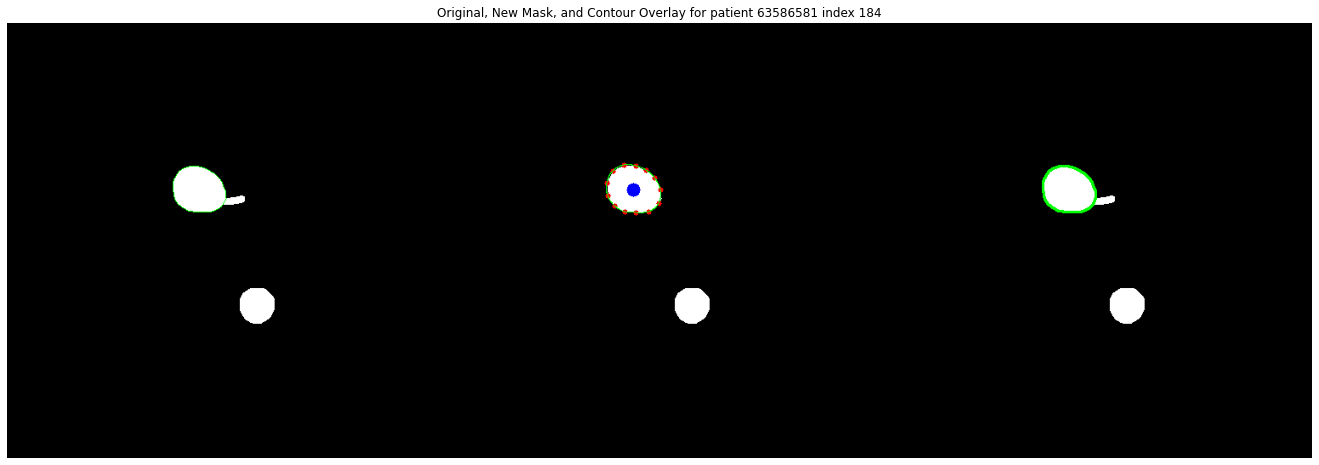

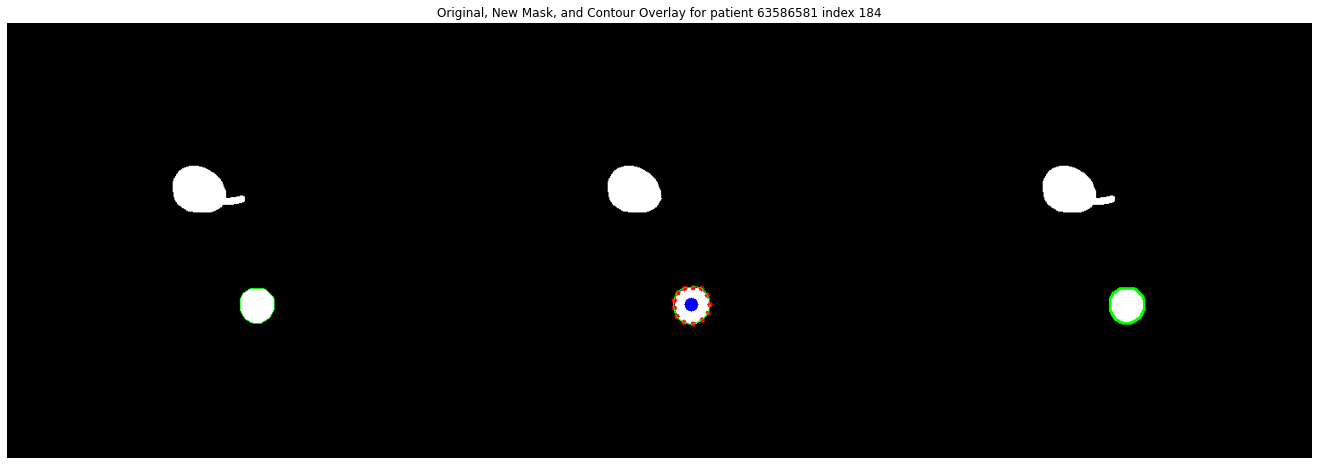

In [18]:
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2
from scipy.interpolate import splprep, splev
from scipy.ndimage import label

# 유클리드 거리 제곱 계산 함수
def ed2(lhs, rhs):
    return (lhs[0] - rhs[0])**2 + (lhs[1] - rhs[1])**2

# 컨투어에서 디펙트 제거 함수
def remove_from_contour(contour, defectsIdx):
    minDist = np.inf
    startIdx, endIdx = 0, 0

    for i in range(len(defectsIdx)):
        for j in range(i + 1, len(defectsIdx)):
            dist = ed2(contour[defectsIdx[i]][0], contour[defectsIdx[j]][0])
            if minDist > dist:
                minDist = dist
                startIdx = defectsIdx[i]
                endIdx = defectsIdx[j]

    if startIdx <= endIdx:
        inside = contour[startIdx:endIdx]
        len1 = 0 if inside.size == 0 else cv2.arcLength(inside, False)
        outside1 = contour[0:startIdx]
        outside2 = contour[endIdx:len(contour)]
        len2 = (0 if outside1.size == 0 else cv2.arcLength(outside1, False)) + (0 if outside2.size == 0 else cv2.arcLength(outside2, False))
        if len2 < len1:
            startIdx, endIdx = endIdx, startIdx
    else:
        inside = contour[endIdx:startIdx]
        len1 = 0 if inside.size == 0 else cv2.arcLength(inside, False)
        outside1 = contour[0:endIdx]
        outside2 = contour[startIdx:len(contour)]
        len2 = (0 if outside1.size == 0 else cv2.arcLength(outside1, False)) + (0 if outside2.size == 0 else cv2.arcLength(outside2, False))
        if len1 < len2:
            startIdx, endIdx = endIdx, startIdx

    if startIdx <= endIdx:
        out = np.concatenate((contour[0:startIdx], contour[endIdx:len(contour)]), axis=0)
    else:
        out = contour[endIdx:startIdx]
    return out

# 돌출부를 제거하는 함수
def remove_defects_from_mask(mask, depth_threshold=2, max_iterations=5):
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)

    for _ in range(max_iterations):
        # 컨투어 찾기
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        if len(contours) == 0:
            raise ValueError("No contours found")
        
        # 가장 큰 컨투어 선택
        contour = sorted(contours, key=cv2.contourArea)[-1]

        # 컨벡스 헐과 디펙트 계산
        hull = cv2.convexHull(contour, returnPoints=False)
        defects = cv2.convexityDefects(contour, hull)

        defectsIdx = []
        for i in range(defects.shape[0]):
            s, e, f, d = defects[i, 0]
            depth = d / 256
            if depth > depth_threshold:  # 임계값 이상 깊이의 디펙트 선택
                defectsIdx.append(f)

        if len(defectsIdx) < 2:
            break

        contour = remove_from_contour(contour, defectsIdx)

        # 컨투어로 마스크 갱신
        mask = np.zeros_like(mask)
        cv2.drawContours(mask, [contour], -1, 255, thickness=cv2.FILLED)

    return contour

# 중심점에서 일정 각도로 직선을 뻗어 마스크의 0값을 만나는 지점을 찾는 함수
def find_intersections_with_mask(mask, center, num_rays=12):
    intersections = []
    angle_step = 360 / num_rays
    h, w = mask.shape

    for i in range(num_rays):
        angle = np.deg2rad(i * angle_step)
        direction = np.array([np.cos(angle), np.sin(angle)])
        
        for length in range(1, max(h, w)):
            x = int(center[0] + length * direction[0])
            y = int(center[1] + length * direction[1])
            
            if x < 0 or y < 0 or x >= w or y >= h or mask[y, x] == 0:
                intersections.append((x, y))
                break
    
    return intersections

# 스플라인 보간법으로 곡선을 생성하는 함수
def create_spline_curve(points):
    points = np.array(points)
    points = np.append(points, [points[0]], axis=0)  # 곡선을 닫기 위해 시작점을 끝에 추가
    tck, u = splprep([points[:, 0], points[:, 1]], s=0, per=True)
    u_new = np.linspace(u.min(), u.max(), 1000)
    x_new, y_new = splev(u_new, tck, der=0)
    return np.array([x_new, y_new], dtype=np.int32).T

# 녹색 외곽선 안의 마스크만 남기는 함수
def mask_inside_contour(mask, contour):
    mask_inside = np.zeros_like(mask)
    cv2.drawContours(mask_inside, [contour], -1, 255, thickness=cv2.FILLED)
    mask_result = cv2.bitwise_and(mask, mask, mask=mask_inside)
    return mask_result

# Patient to index mapping
patient_index_map = {
    '63602870': [142, 146],
    '63597118': [167, 174],
    '63611139': [172, 175],
    '65522033': [157, 166],
    '65019823': [156, 157, 163, 164],
    '63619380': [155, 160],
    '63586581': [177, 184]
}

# 반복 처리
for patient, index_list in patient_index_map.items():
    label_path = f"/home/seokjun/nas199_kidney/Angiography/Angiography/2. CT/15. TAVI/DatasetForDL_2024/{patient}/label"
    
    for index in index_list:
        image_path = os.path.join(label_path, str(index) + ".png")
        
        # 이미지 열기
        img = Image.open(image_path)
        
        # 이미지 numpy 배열로 변환
        img_array = np.array(img)
        
        # 마스크 추출 (여기서는 흰색 픽셀을 마스크로 가정)
        mask = np.stack([img_array]*3, axis=-1)  # 3채널 이미지로 변환
        
        # 마스크 레이블링 (2개 이상의 마스크가 있는지 확인)
        labeled_mask, num_features = label(mask[:, :, 0])

        # 각 레이블에 대해 처리
        contours_combined = []
        for i in range(1, num_features + 1):
            individual_mask = np.zeros_like(mask)
            individual_mask[labeled_mask == i] = 255
            
            # 디펙트 제거 후 컨투어를 이용해 윤곽선 추출
            contour = remove_defects_from_mask(individual_mask, depth_threshold=3, max_iterations=50)  # max_iterations 추가
            contours_combined.append(contour)
        
        # 새로운 마스크 생성
        new_mask = np.zeros_like(img_array)
        for contour in contours_combined:
            cv2.drawContours(new_mask, [contour], -1, 255, thickness=cv2.FILLED)
        
        # 외곽선의 중심(무게중심) 계산 및 스플라인 곡선 생성
        for contour in contours_combined:
            M = cv2.moments(contour)
            if M["m00"] != 0:
                cX = int(M["m10"] / M["m00"])
                cY = int(M["m01"] / M["m00"])
            else:
                cX, cY = 0, 0
            
            center = np.array([cX, cY])
            
            # 중심에서 마스크의 0 값을 만나는 지점 계산
            num_rays = 13
            intersections = find_intersections_with_mask(new_mask, center, num_rays=num_rays)
            
            # 원본 이미지와 새로운 마스크 위에 중심점과 교차점 그리기
            new_mask_with_points = cv2.cvtColor(new_mask, cv2.COLOR_GRAY2BGR)
            cv2.circle(new_mask_with_points, (cX, cY), 8, (0, 0, 255), -1)  # 중심점 (빨간색)
            
            # 바깥 점들 작게 표시
            for point in intersections:
                cv2.circle(new_mask_with_points, point, 3, (255, 0, 0), -1)
            
            # 바깥 점들을 스플라인 곡선으로 이어줌
            spline_curve = create_spline_curve(intersections)
            cv2.polylines(new_mask_with_points, [spline_curve], isClosed=True, color=(0, 255, 0), thickness=1)
            
            # 녹색 외곽선 안의 마스크만 남기기
            mask_only_inside = mask_inside_contour(new_mask, spline_curve)
            mask_only_inside_colored = cv2.cvtColor(mask_only_inside, cv2.COLOR_GRAY2BGR)
            
            # 내부 마스크에 대한 돌출부 제거 수행
            contour_after_defect_removal = remove_defects_from_mask(mask_only_inside_colored, depth_threshold=3, max_iterations=50)
            
            # 첫번째 컷 : 원본위에 첫번째 돌출부 제거한 윤곽선
            original_with_first = cv2.cvtColor(img_array, cv2.COLOR_GRAY2BGR)
            cv2.drawContours(original_with_first, [contour], -1, (0, 255, 0), thickness=1)
            
            # 원본 이미지 위에 윤곽선만 그리기
            original_with_contour = cv2.cvtColor(img_array, cv2.COLOR_GRAY2BGR)
            cv2.drawContours(original_with_contour, [contour_after_defect_removal], -1, (0, 255, 0), thickness=2)
            
            # 원본 이미지, 새로운 마스크, 그리고 윤곽선이 그려진 이미지를 나란히 배치
            combined_image = np.hstack((original_with_first, new_mask_with_points, original_with_contour))
            
            # 결과 시각화
            plt.figure(figsize=(24, 8))
            plt.imshow(combined_image)
            plt.title(f"Original, New Mask, and Contour Overlay for patient {patient} index {index}")
            plt.axis('off')
            plt.show()


# 과정_2

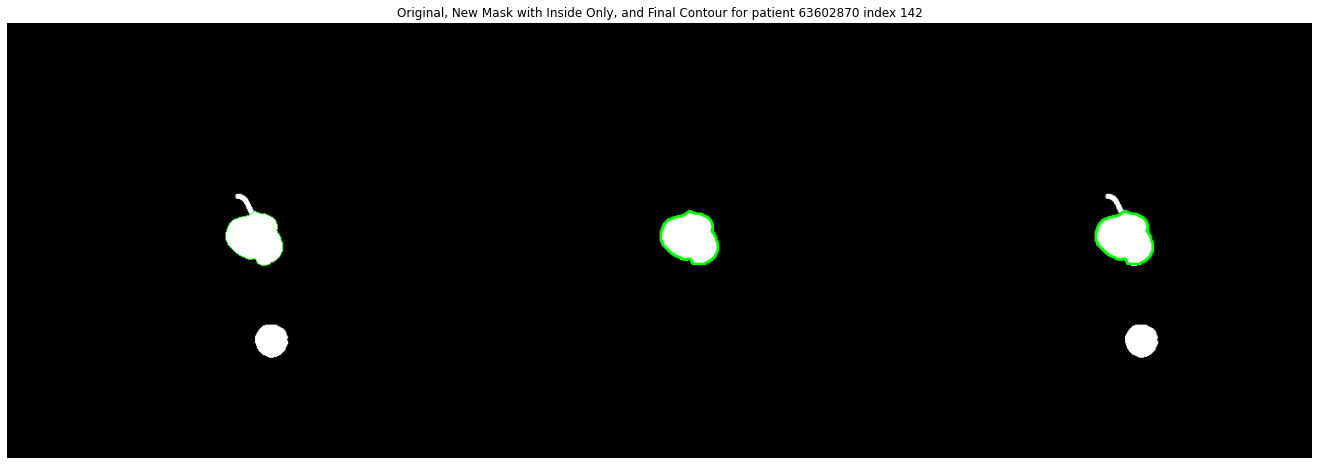

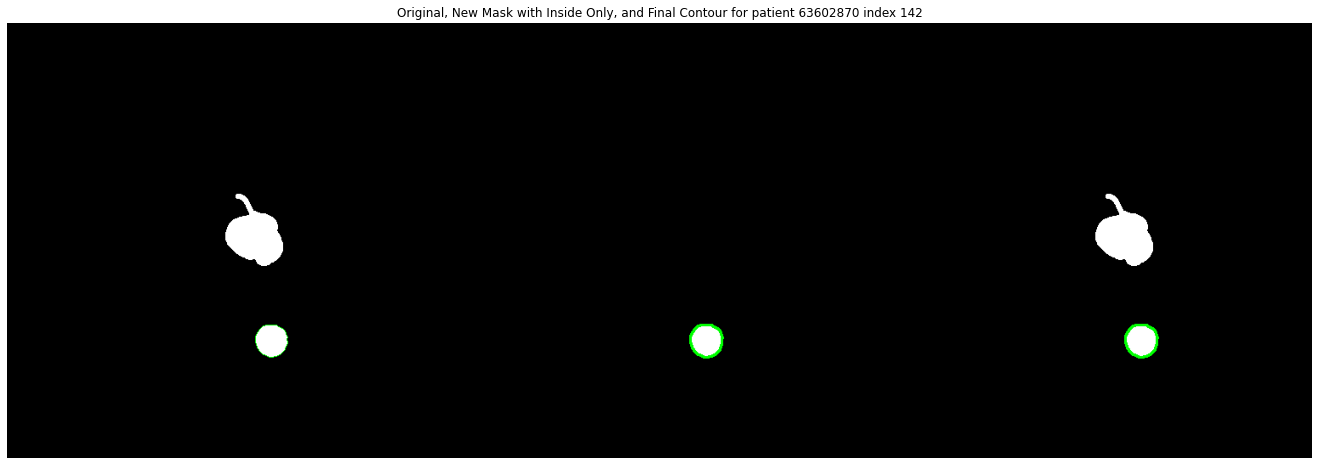

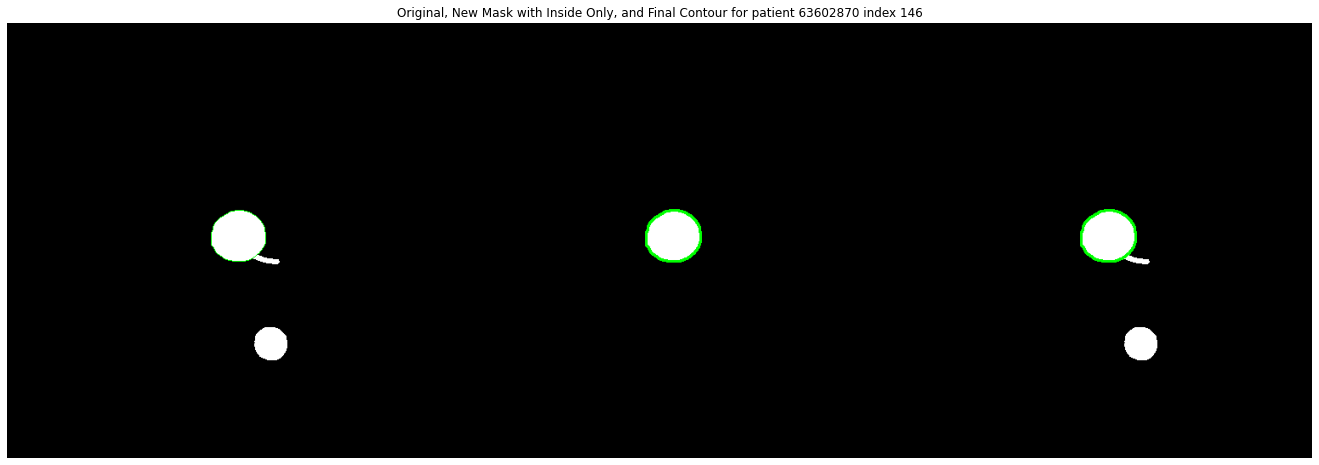

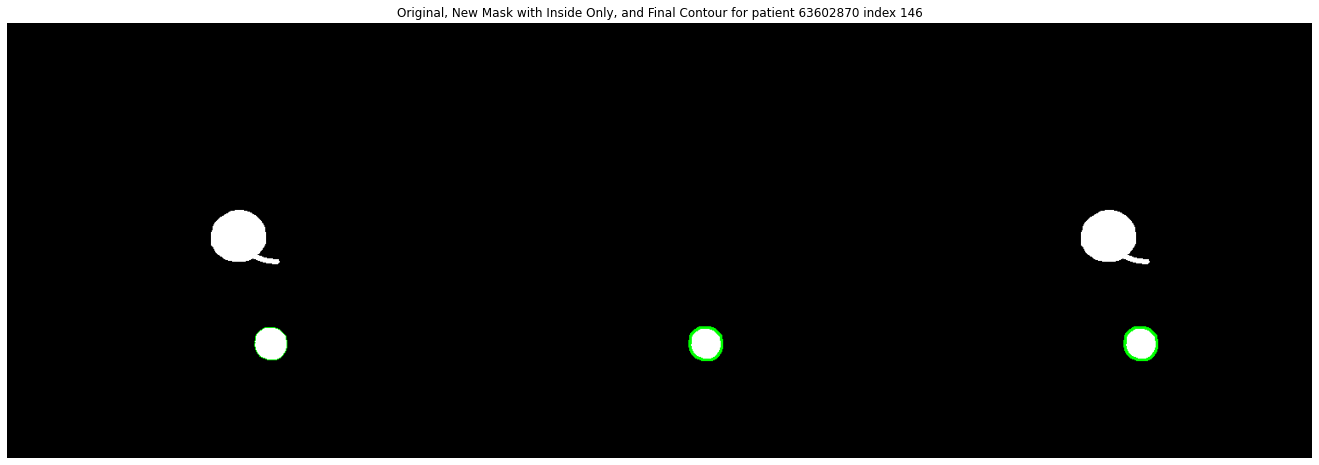

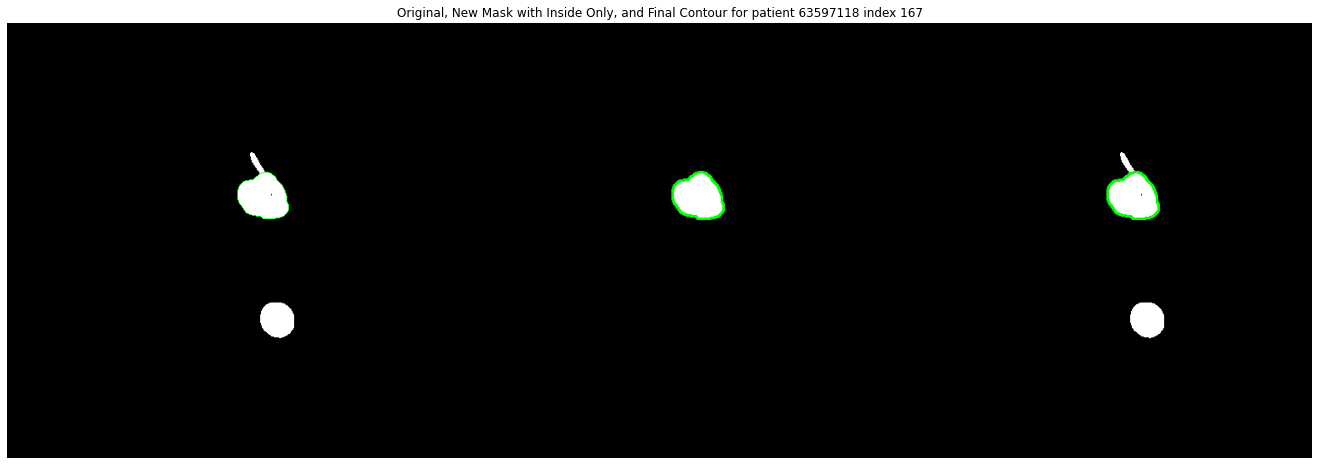

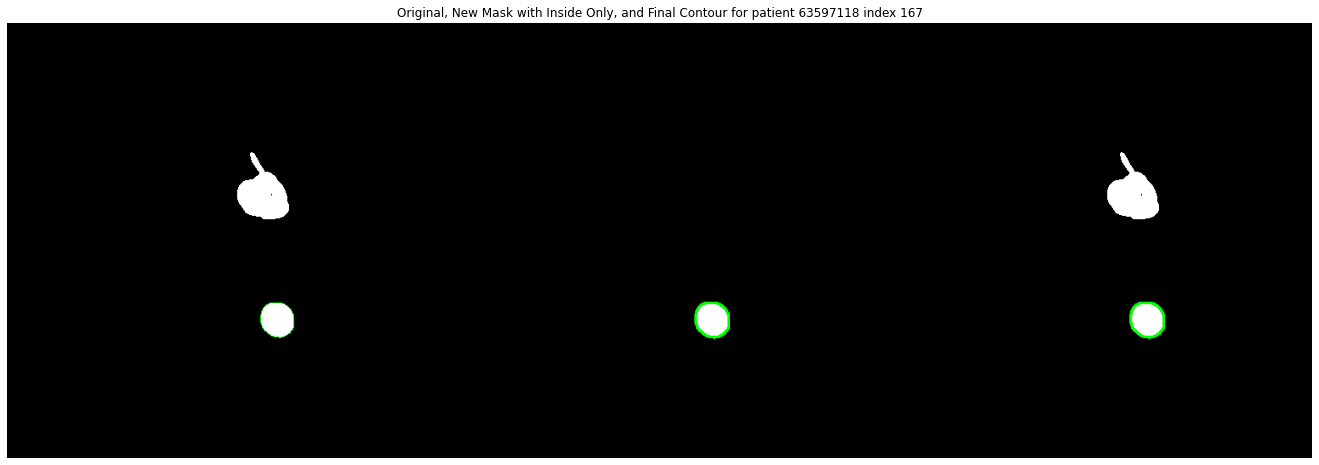

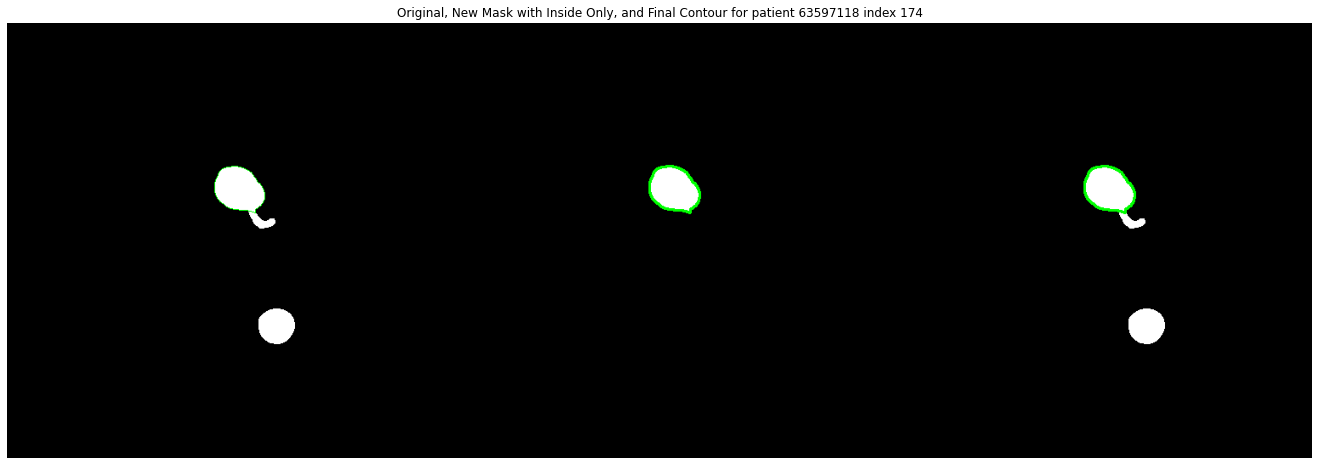

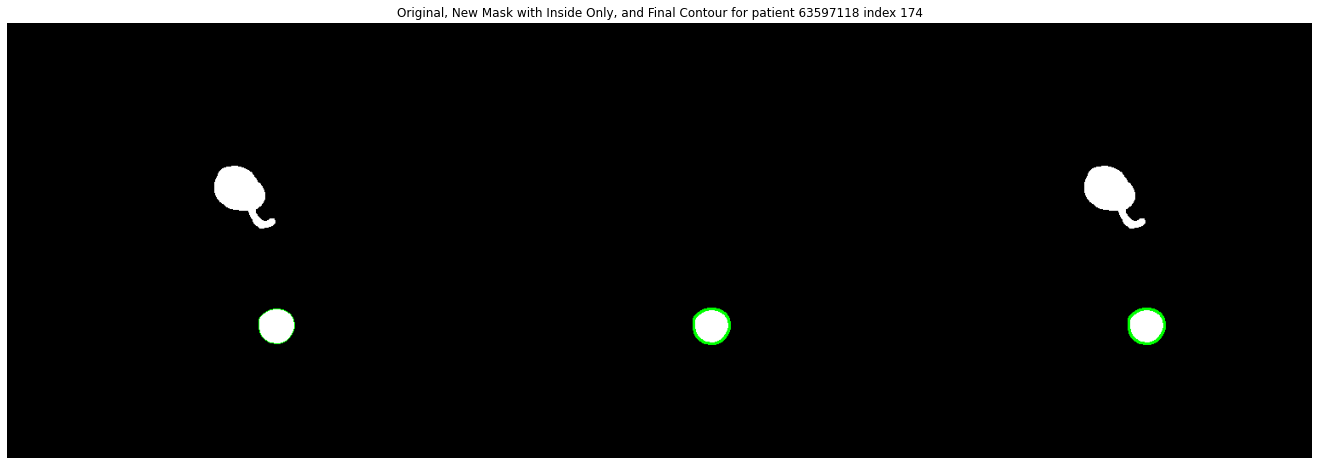

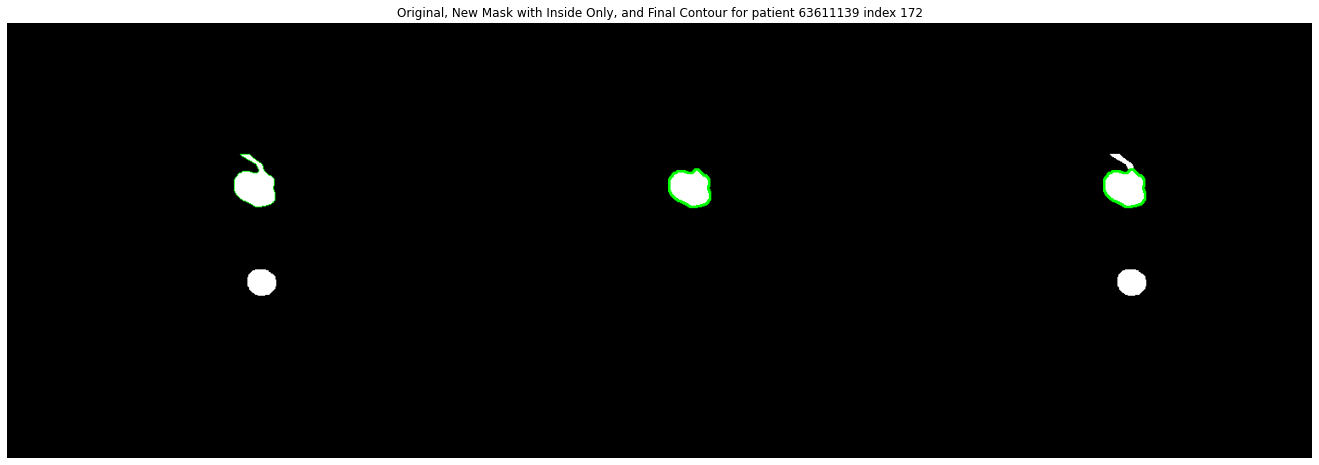

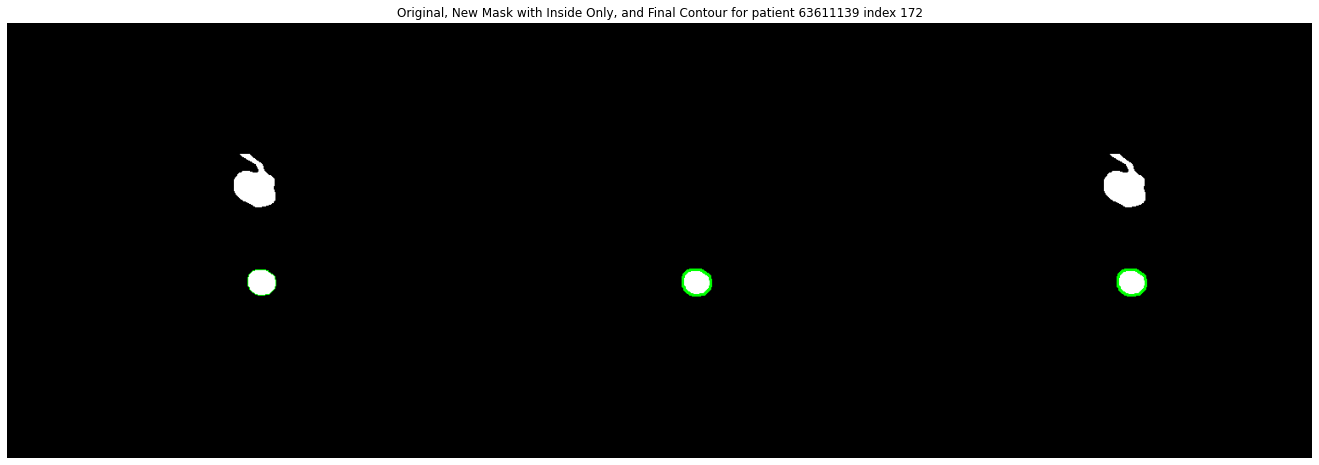

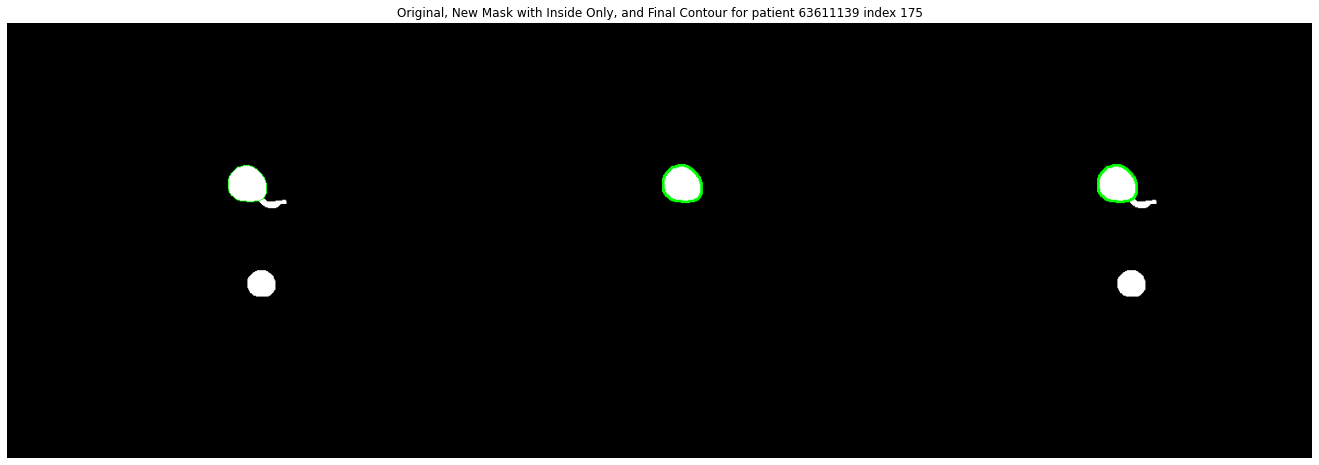

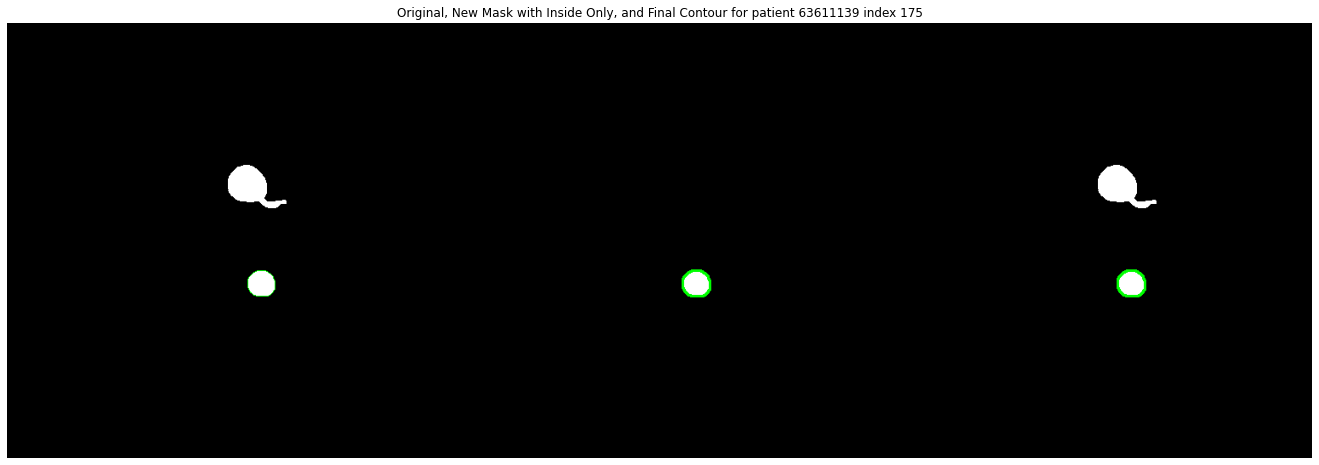

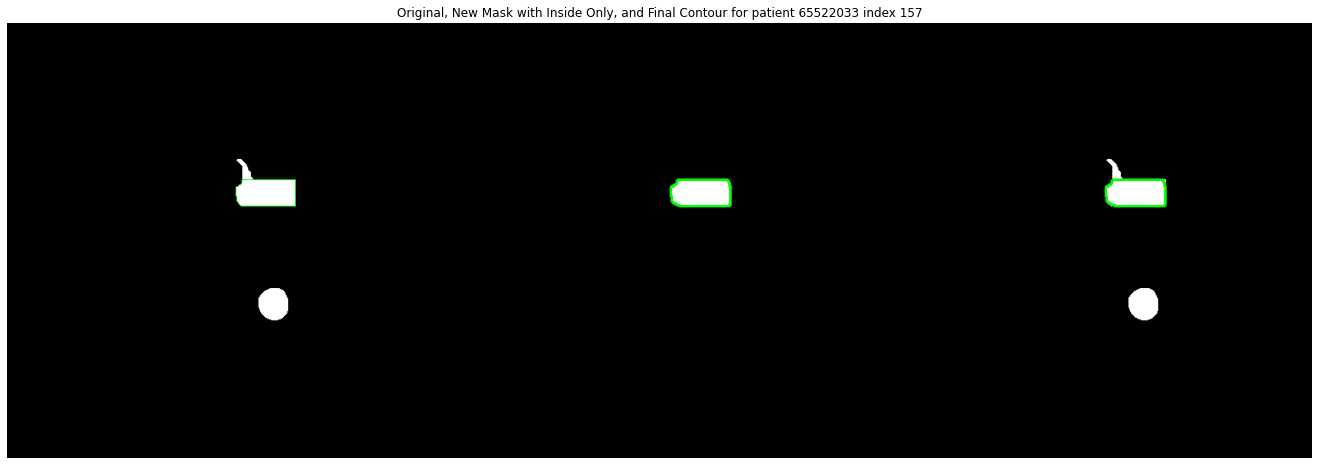

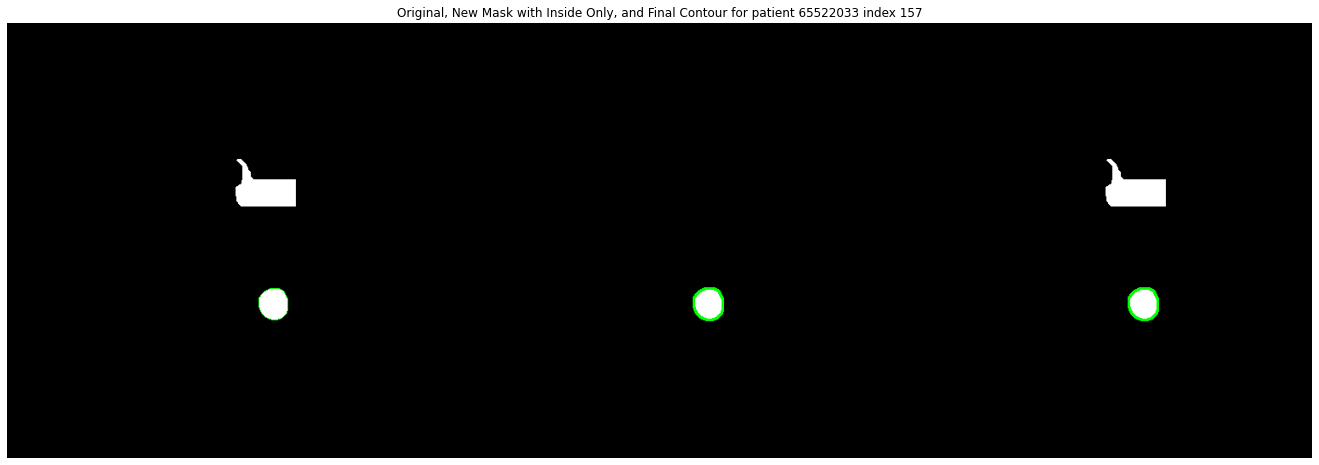

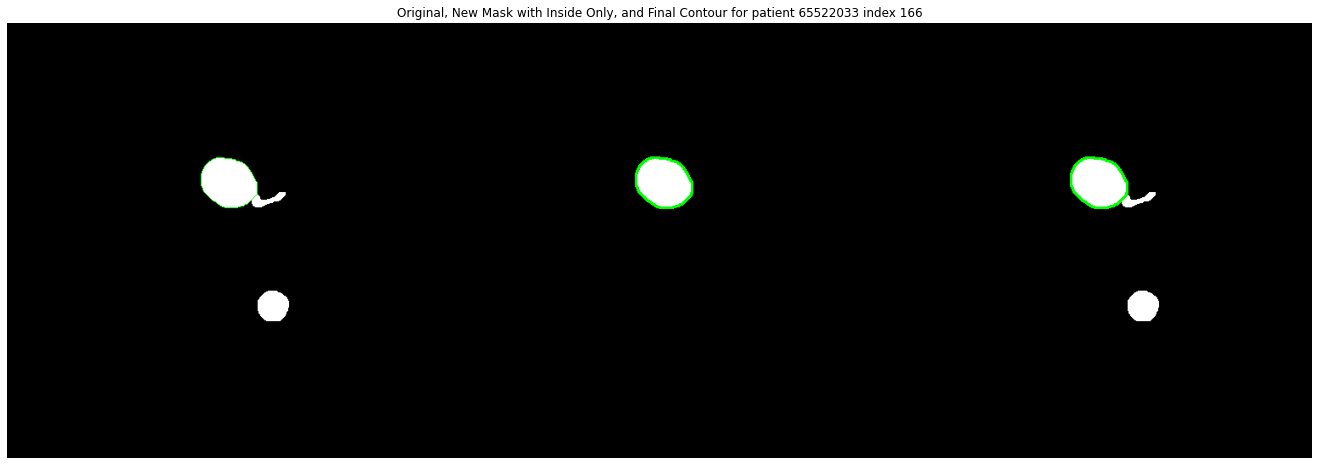

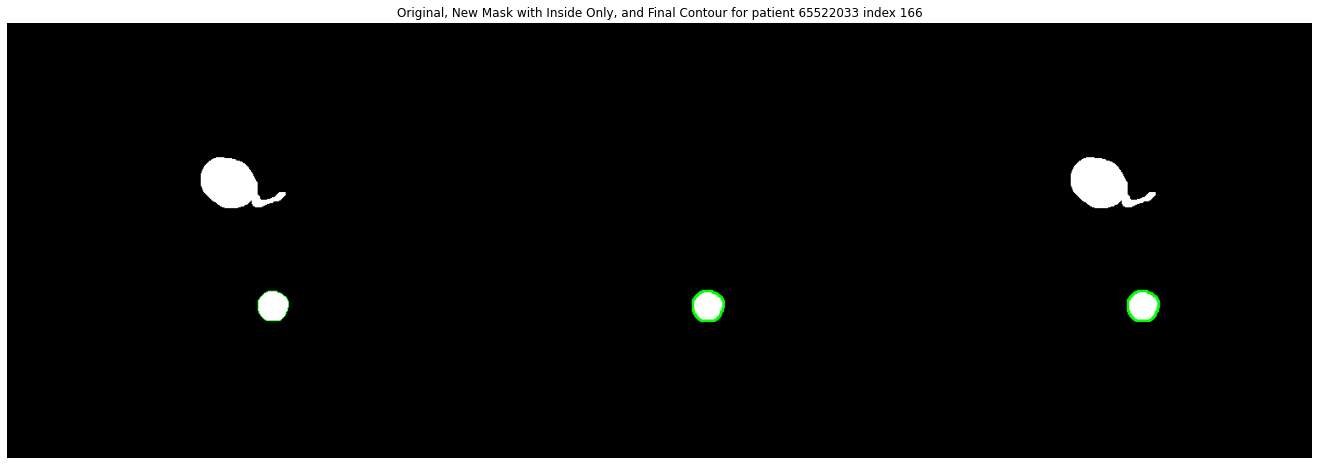

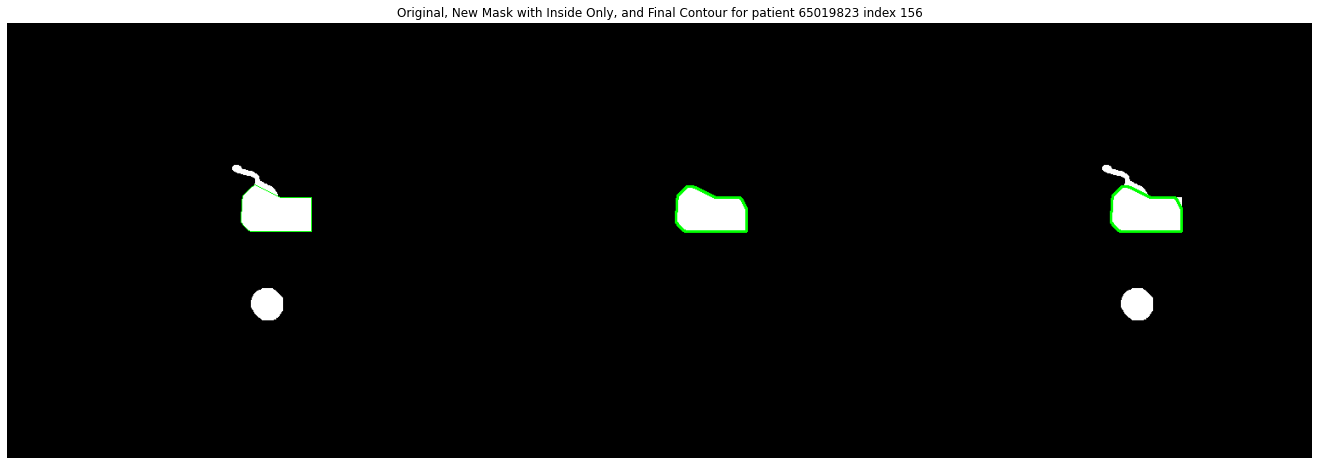

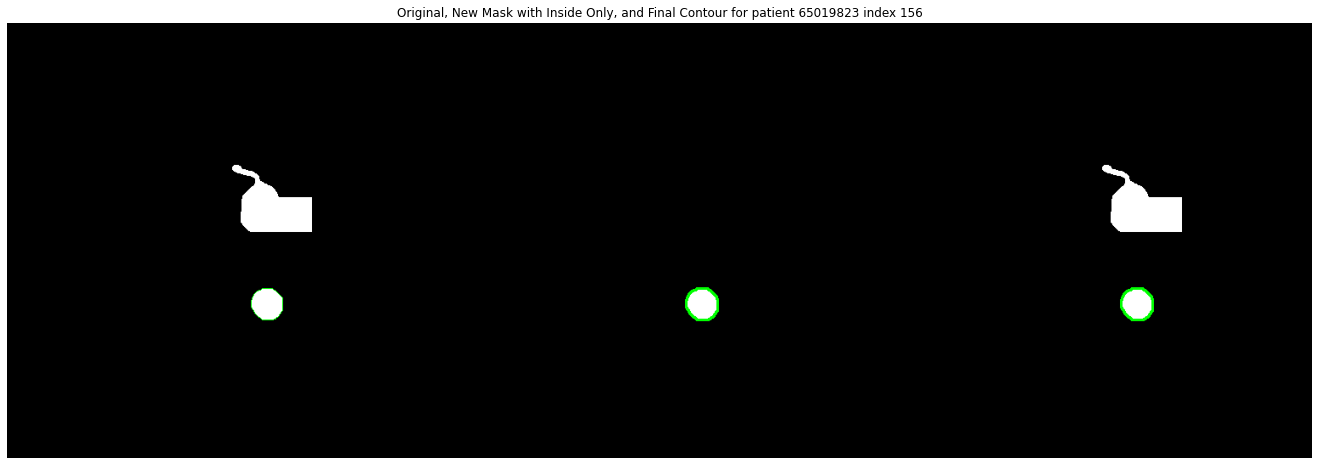

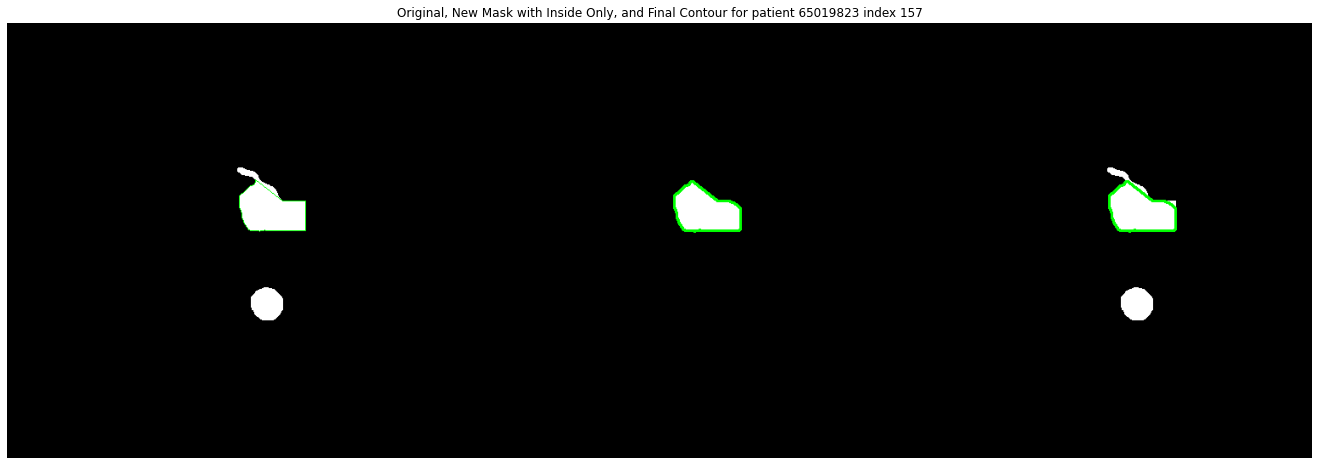

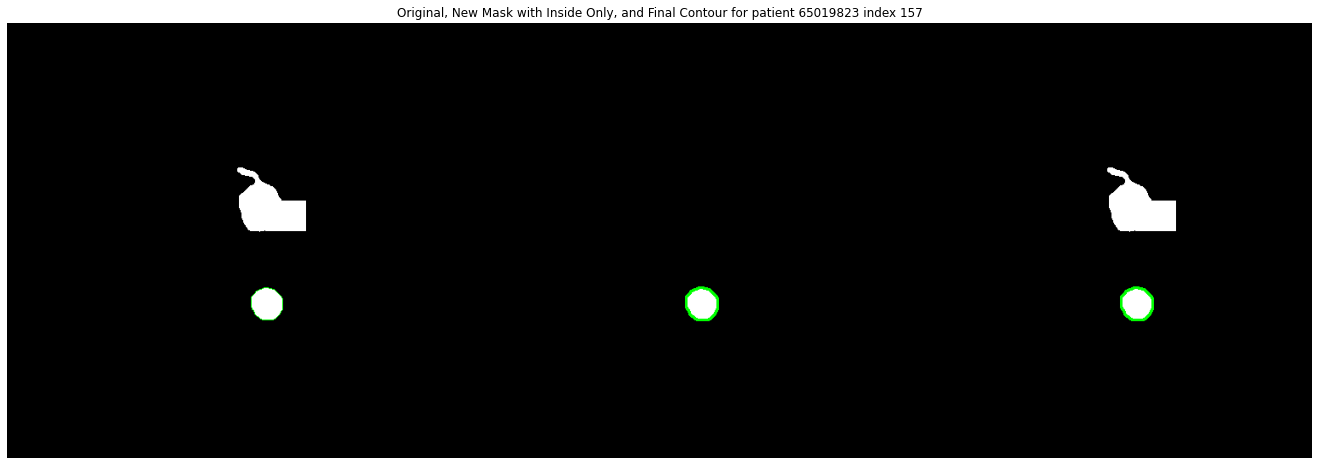

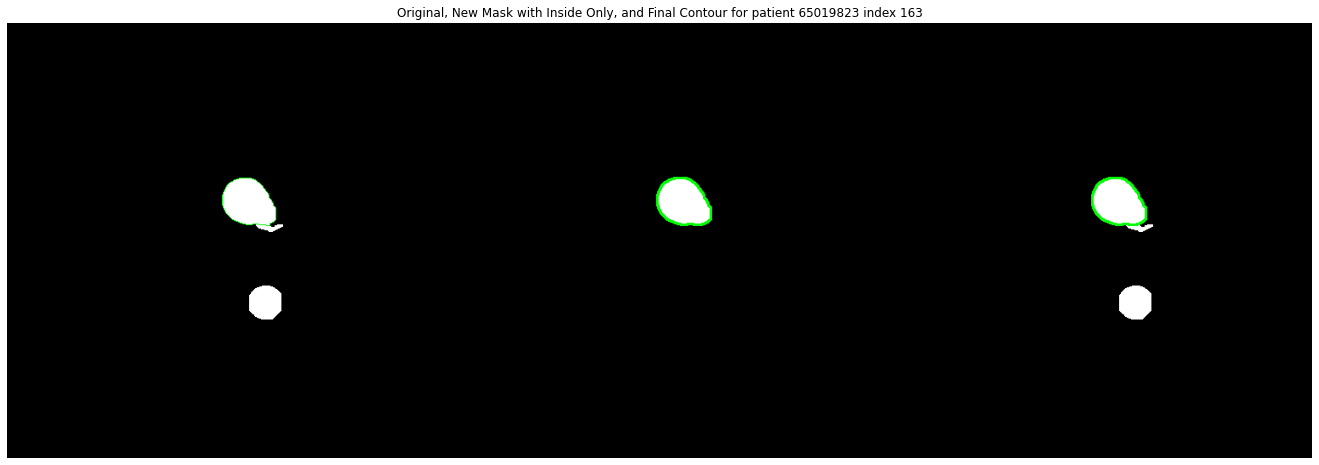

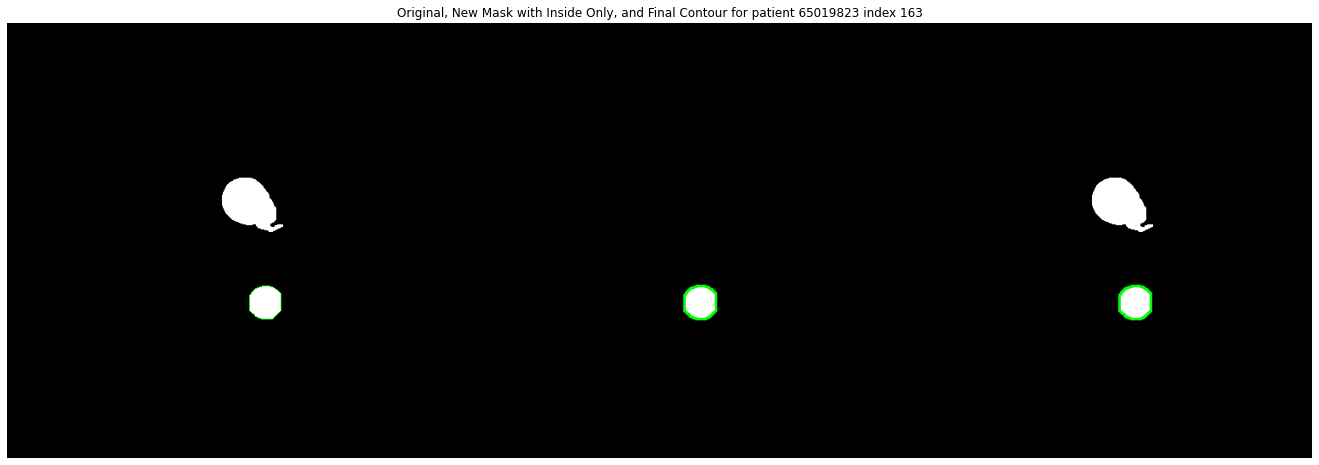

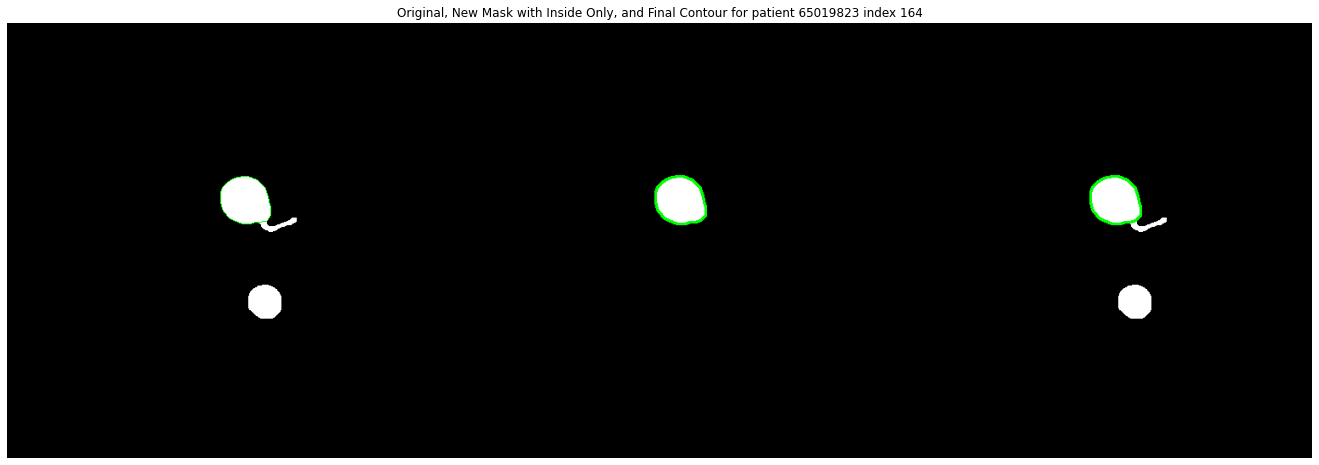

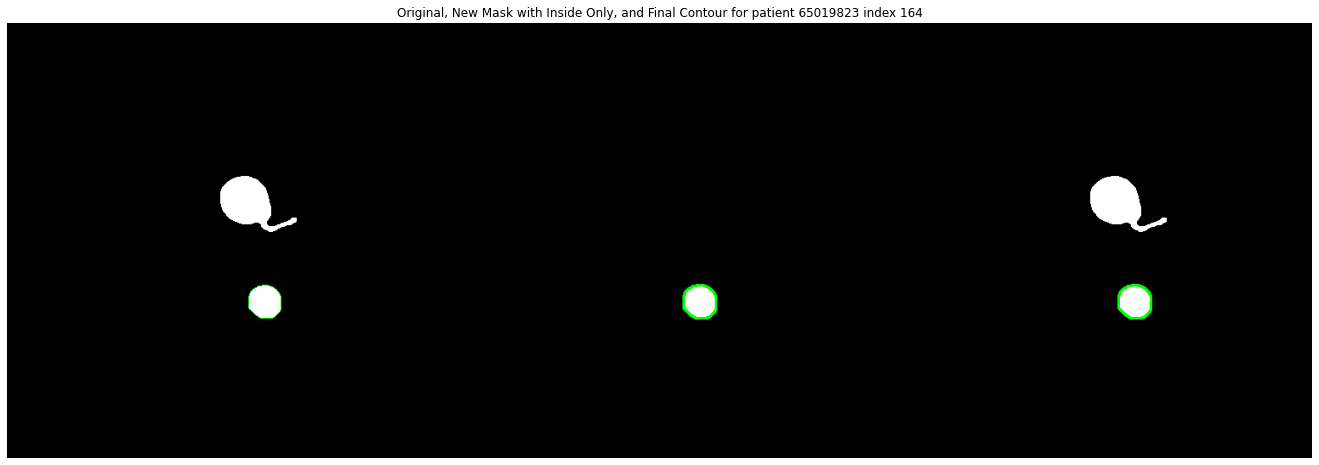

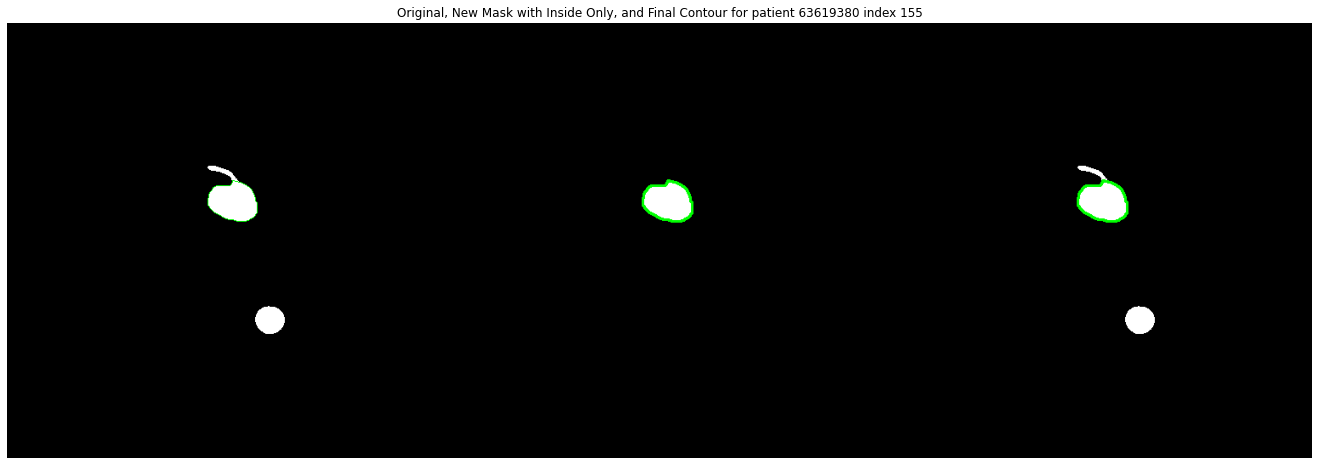

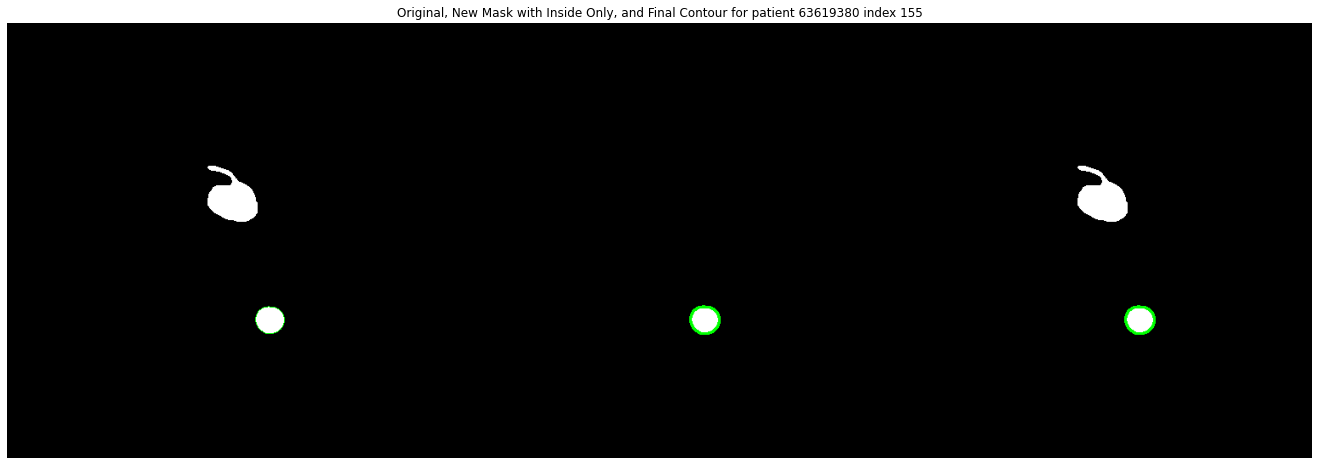

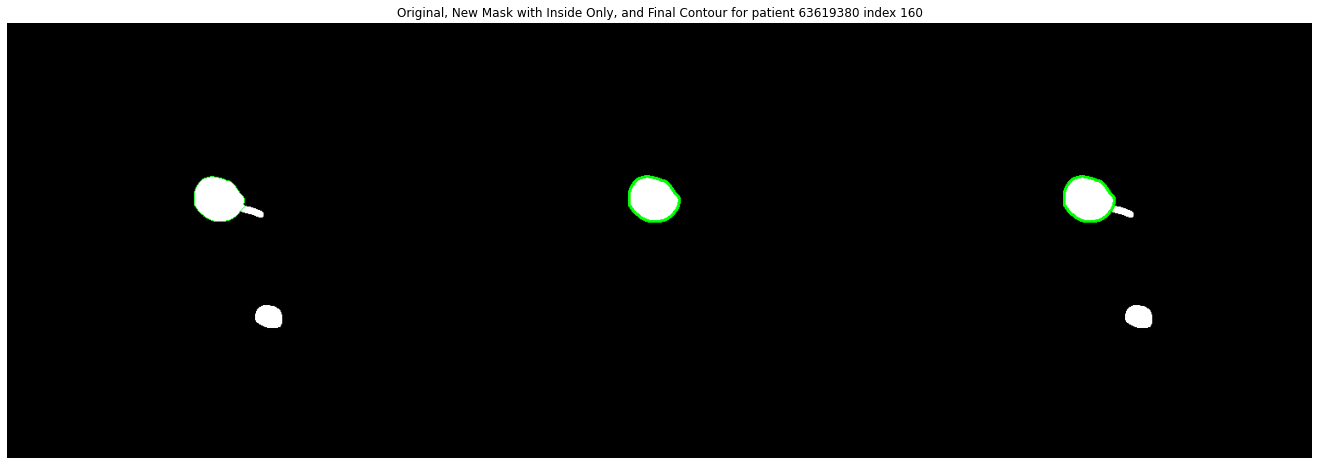

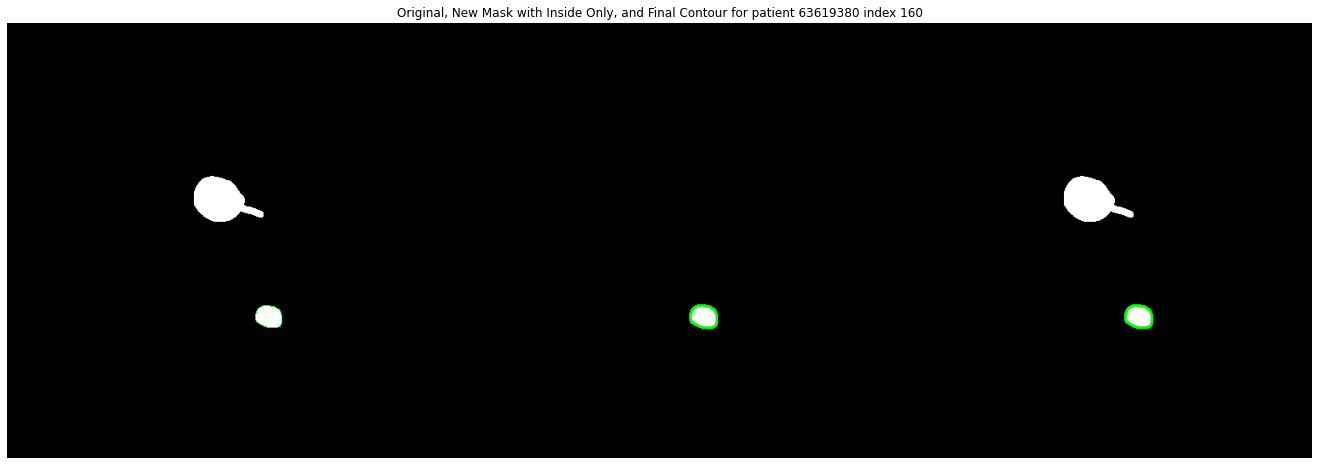

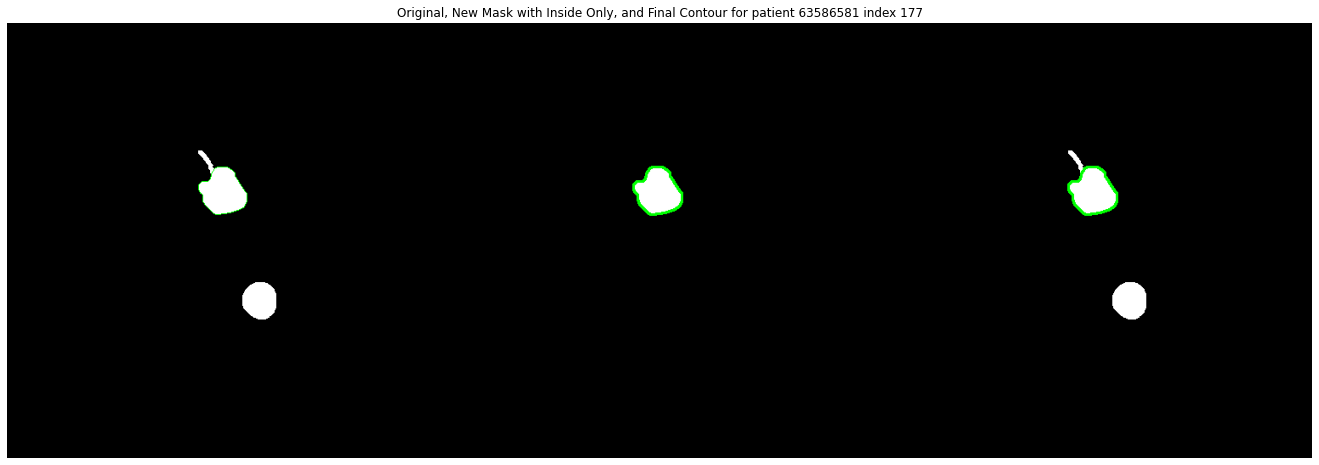

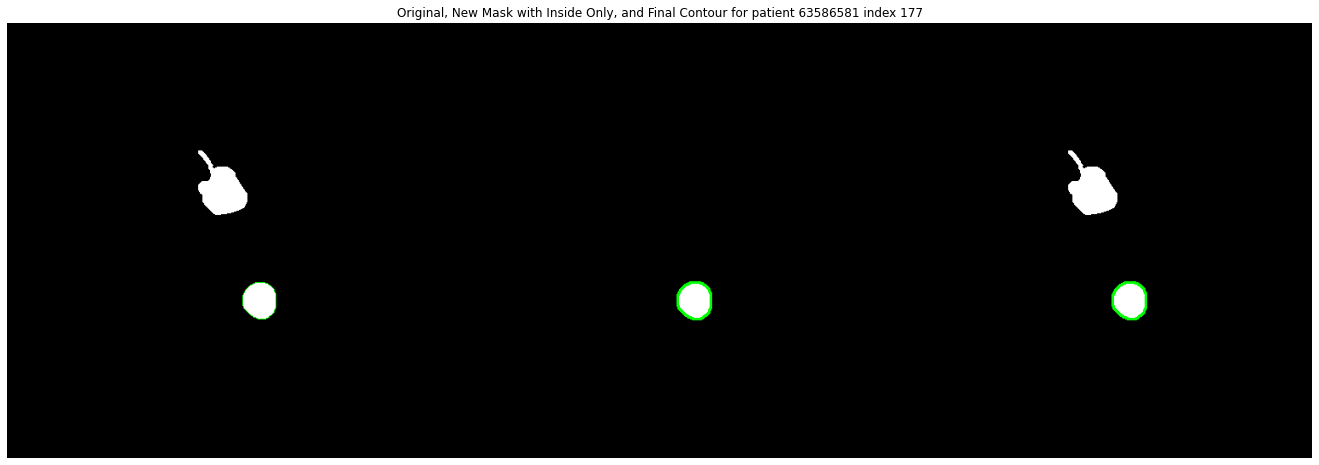

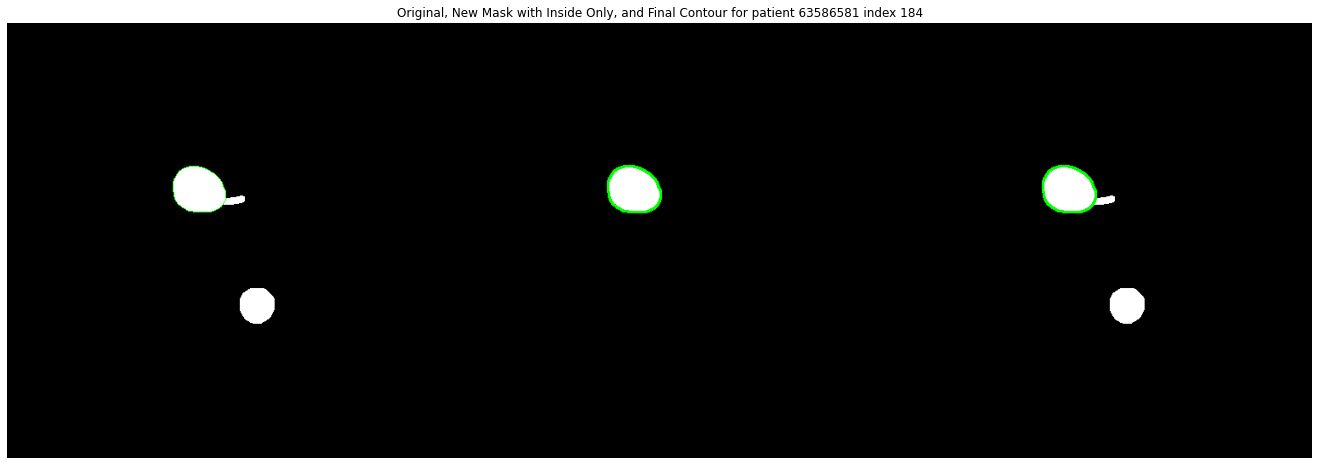

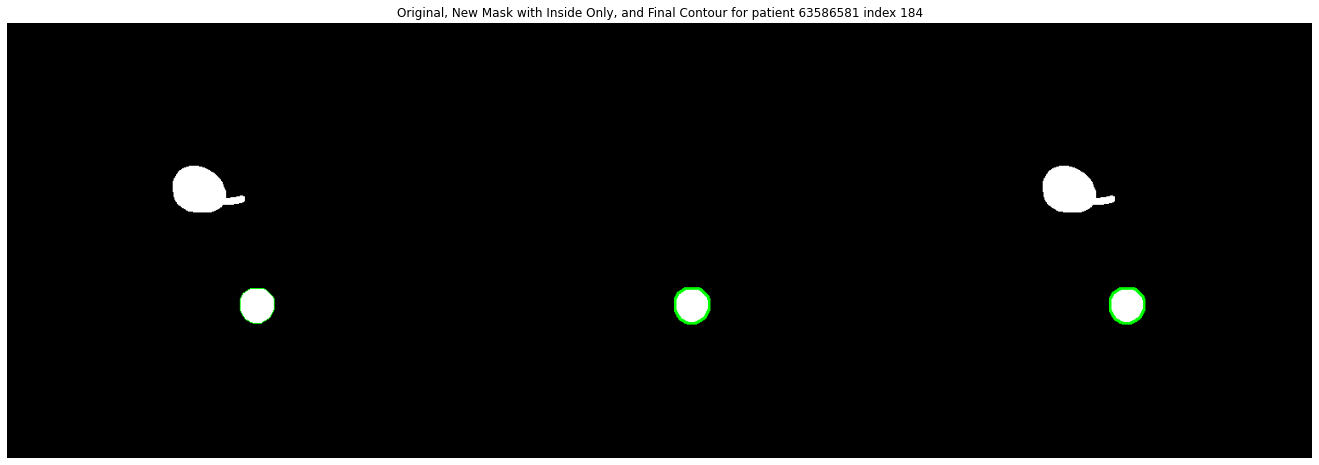

In [15]:
# 반복 처리
for patient, index_list in patient_index_map.items():
    label_path = f"/home/seokjun/nas199_kidney/Angiography/Angiography/2. CT/15. TAVI/DatasetForDL_2024/{patient}/label"
    
    for index in index_list:
        image_path = os.path.join(label_path, str(index) + ".png")
        
        # 이미지 열기
        img = Image.open(image_path)
        
        # 이미지 numpy 배열로 변환
        img_array = np.array(img)
        
        # 마스크 추출 (여기서는 흰색 픽셀을 마스크로 가정)
        mask = np.stack([img_array]*3, axis=-1)  # 3채널 이미지로 변환
        
        # 마스크 레이블링 (2개 이상의 마스크가 있는지 확인)
        labeled_mask, num_features = label(mask[:, :, 0])

        # 각 레이블에 대해 처리
        contours_combined = []
        for i in range(1, num_features + 1):
            individual_mask = np.zeros_like(mask)
            individual_mask[labeled_mask == i] = 255
            
            # 디펙트 제거 후 컨투어를 이용해 윤곽선 추출
            contour = remove_defects_from_mask(individual_mask, depth_threshold=3, max_iterations=50)  # max_iterations 추가
            contours_combined.append(contour)
        
        # 새로운 마스크 생성
        new_mask = np.zeros_like(img_array)
        for contour in contours_combined:
            cv2.drawContours(new_mask, [contour], -1, 255, thickness=cv2.FILLED)
        
        # 외곽선의 중심(무게중심) 계산 및 스플라인 곡선 생성
        for contour in contours_combined:
            M = cv2.moments(contour)
            if M["m00"] != 0:
                cX = int(M["m10"] / M["m00"])
                cY = int(M["m01"] / M["m00"])
            else:
                cX, cY = 0, 0
            
            center = np.array([cX, cY])
            
            # 중심에서 마스크의 0 값을 만나는 지점 계산
            num_rays = 13
            intersections = find_intersections_with_mask(new_mask, center, num_rays=num_rays)
            
            # 원본 이미지와 새로운 마스크 위에 중심점과 교차점 그리기
            new_mask_with_points = cv2.cvtColor(new_mask, cv2.COLOR_GRAY2BGR)
            cv2.circle(new_mask_with_points, (cX, cY), 8, (0, 0, 255), -1)  # 중심점 (빨간색)
            
            # 바깥 점들 작게 표시
            for point in intersections:
                cv2.circle(new_mask_with_points, point, 3, (255, 0, 0), -1)
            
            # 바깥 점들을 스플라인 곡선으로 이어줌
            spline_curve = create_spline_curve(intersections)
            cv2.polylines(new_mask_with_points, [spline_curve], isClosed=True, color=(0, 255, 0), thickness=1)
            
            # 녹색 외곽선 안의 마스크만 남기기
            mask_only_inside = mask_inside_contour(new_mask, spline_curve)
            mask_only_inside_colored = cv2.cvtColor(mask_only_inside, cv2.COLOR_GRAY2BGR)
            
            # 내부 마스크에 대한 돌출부 제거 수행
            contour_after_defect_removal = remove_defects_from_mask(mask_only_inside_colored, depth_threshold=3, max_iterations=50)
            
            # 첫번째 컷 : 원본위에 첫번째 돌출부 제거한 윤곽선
            original_with_first = cv2.cvtColor(img_array, cv2.COLOR_GRAY2BGR)
            cv2.drawContours(original_with_first, [contour], -1, (0, 255, 0), thickness=1)
            
            # 두번째 컷 : 새로운 마스크와 윤곽선 (녹색 외곽선 안의 마스크만 남김)
            new_mask_with_inside_only = mask_only_inside_colored.copy()
            cv2.drawContours(new_mask_with_inside_only, [contour_after_defect_removal], -1, (0, 255, 0), thickness=2)
            
            # 세번째 컷 : 원본 이미지 위에 최종 윤곽선만 그리기
            original_with_contour = cv2.cvtColor(img_array, cv2.COLOR_GRAY2BGR)
            cv2.drawContours(original_with_contour, [contour_after_defect_removal], -1, (0, 255, 0), thickness=2)
            
            # 결과 이미지를 나란히 배치
            combined_image = np.hstack((original_with_first, new_mask_with_inside_only, original_with_contour))
            
            # 결과 시각화
            plt.figure(figsize=(24, 8))
            plt.imshow(combined_image)
            plt.title(f"Original, New Mask with Inside Only, and Final Contour for patient {patient} index {index}")
            plt.axis('off')
            plt.show()


# 최종결과물 - 저장

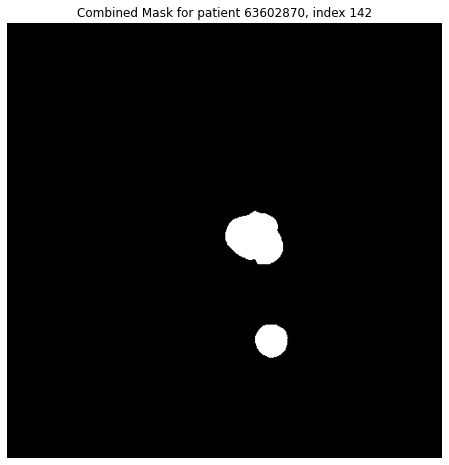

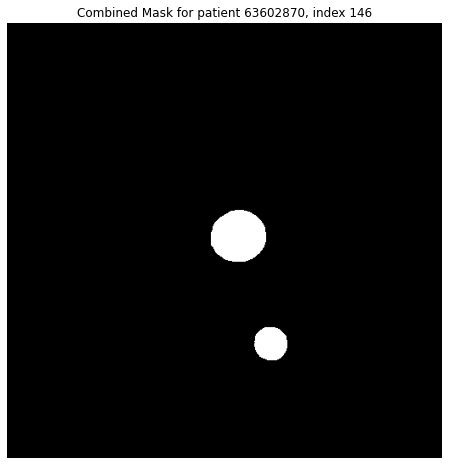

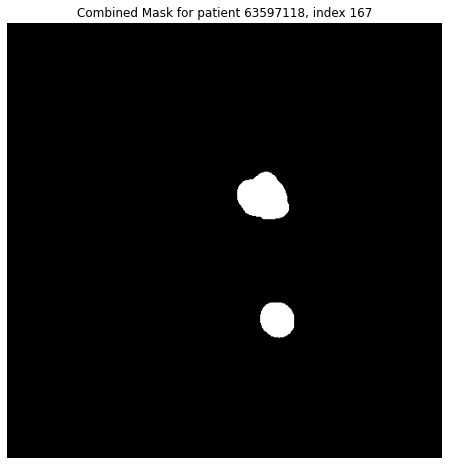

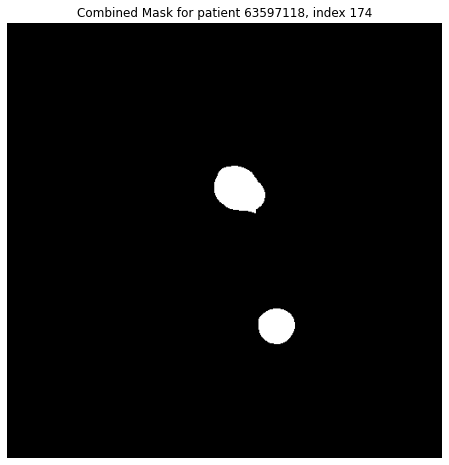

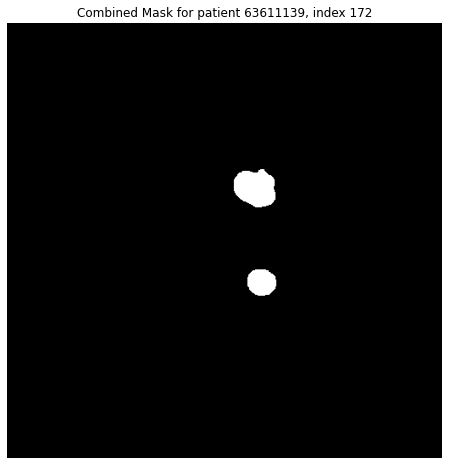

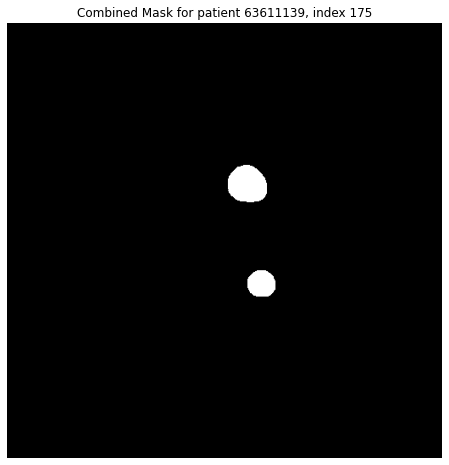

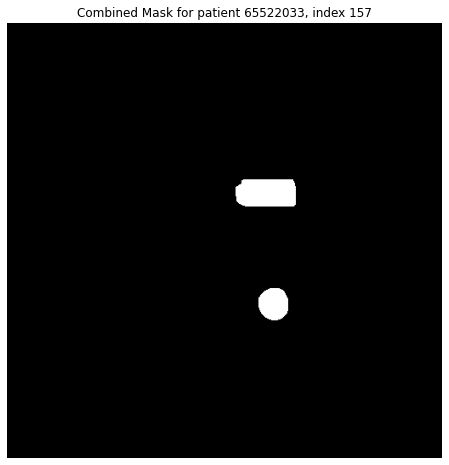

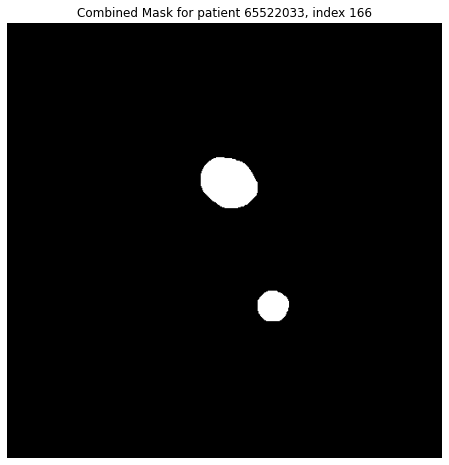

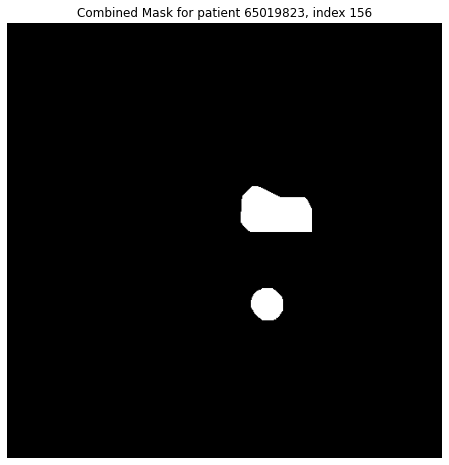

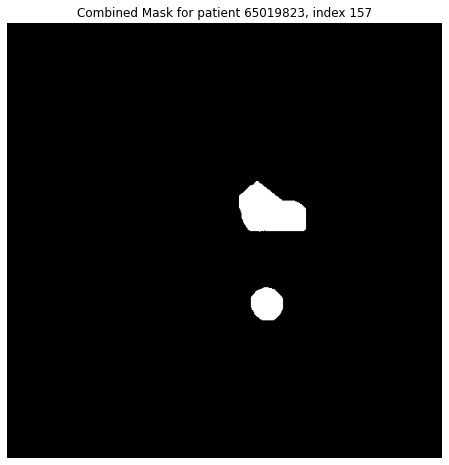

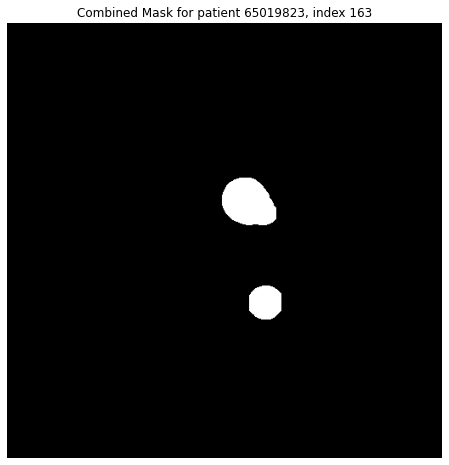

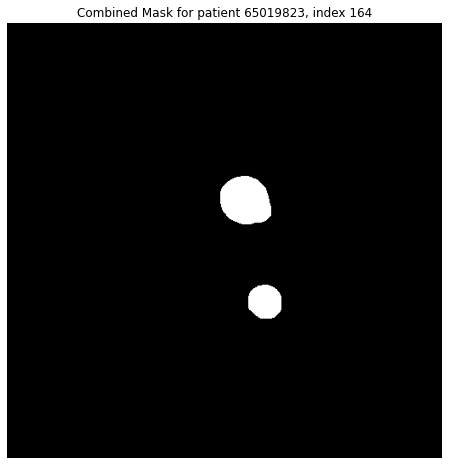

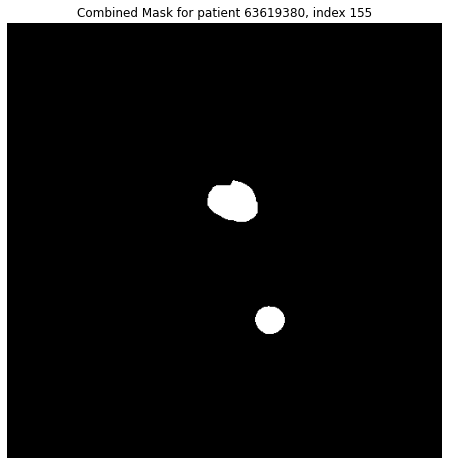

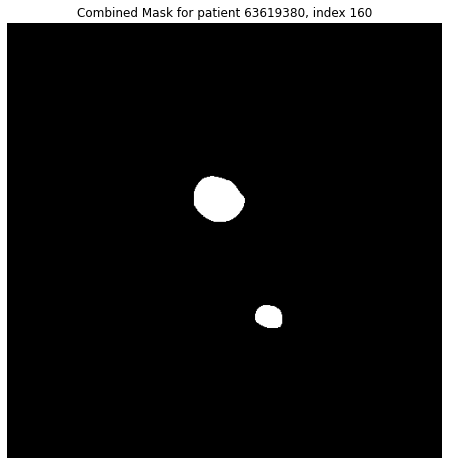

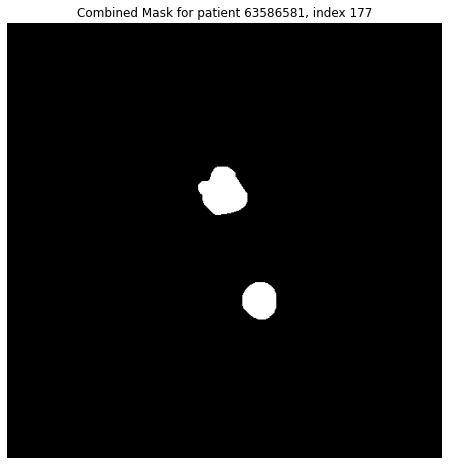

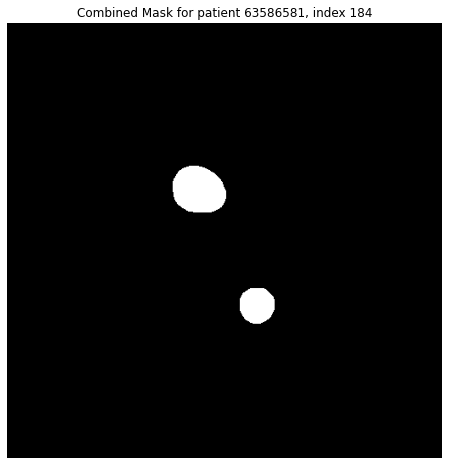

In [16]:
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2
from scipy.ndimage import label

# 저장 경로 설정
save_path = t

# 환자별로 처리된 이미지를 저장할 리스트 생성
for patient, index_list in patient_index_map.items():
    label_path = t
    
    # 환자별로 폴더 생성
    patient_save_path = os.path.join(save_path, patient)
    if not os.path.exists(patient_save_path):
        os.makedirs(patient_save_path)
    
    for index in index_list:
        image_path = os.path.join(label_path, str(index) + ".png")
        
        # 이미지 열기
        img = Image.open(image_path)
        
        # 이미지 numpy 배열로 변환
        img_array = np.array(img)
        
        # 마스크 추출 (여기서는 흰색 픽셀을 마스크로 가정)
        mask = np.stack([img_array]*3, axis=-1)  # 3채널 이미지로 변환
        
        # 마스크 레이블링 (2개 이상의 마스크가 있는지 확인)
        labeled_mask, num_features = label(mask[:, :, 0])

        # 최종 마스크를 저장할 빈 캔버스 생성
        final_mask = np.zeros_like(img_array)

        # 각 레이블에 대해 처리
        for i in range(1, num_features + 1):
            individual_mask = np.zeros_like(mask)
            individual_mask[labeled_mask == i] = 255
            
            # 디펙트 제거 후 컨투어를 이용해 윤곽선 추출
            contour = remove_defects_from_mask(individual_mask, depth_threshold=3, max_iterations=50)
            
            # 새로운 마스크 생성
            new_mask = np.zeros_like(img_array)
            cv2.drawContours(new_mask, [contour], -1, 255, thickness=cv2.FILLED)
        
            # 외곽선의 중심(무게중심) 계산 및 스플라인 곡선 생성
            M = cv2.moments(contour)
            if M["m00"] != 0:
                cX = int(M["m10"] / M["m00"])
                cY = int(M["m01"] / M["m00"])
            else:
                cX, cY = 0, 0
            
            center = np.array([cX, cY])
            
            # 중심에서 마스크의 0 값을 만나는 지점 계산
            num_rays = 13
            intersections = find_intersections_with_mask(new_mask, center, num_rays=num_rays)
            
            # 바깥 점들을 스플라인 곡선으로 이어줌
            spline_curve = create_spline_curve(intersections)
            
            # 녹색 외곽선 안의 마스크만 남기기
            mask_only_inside = mask_inside_contour(new_mask, spline_curve)
            
            # 최종 결과 마스크에 추가
            final_mask = cv2.bitwise_or(final_mask, mask_only_inside)

        # 최종 결합된 마스크 이미지를 저장
        result_image = Image.fromarray(final_mask)
        result_image_path = os.path.join(patient_save_path, f"{index}.png")
        result_image.save(result_image_path)
        
        # 결과를 시각화하여 확인 (선택 사항)
        plt.figure(figsize=(8, 8))
        plt.imshow(final_mask, cmap='gray')
        plt.title(f"Combined Mask for patient {patient}, index {index}")
        plt.axis('off')
        plt.show()


In [ ]:
# 맨 아래 최종결과물

# 교수님 주신사이트 참고
- https://stackoverflow.com/questions/35226993/how-to-crop-away-convexity-defects

import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

patient_index_map = {
    '63602870': [142, 146],
    '63597118': [167, 174],
    '63611139': [172, 175],
    '65522033': [157, 166],
    '65019823': [156, 163, 164],
    '63619380': [155, 160],
    '63586581': [177, 184]
}

# 경로 설정
patients = ['63597118']
patient = patients[0]
label_path = f"/home/seokjun/nas199_kidney/Angiography/Angiography/2. CT/15. TAVI/DatasetForDL_2024/{patient}/label"

index_list = ["167", "174"]

for index in index_list:
    image_path = os.path.join(label_path, index + ".png")
    
    # 이미지 열기
    img = Image.open(image_path)
    
    # 이미지 numpy 배열로 변환
    img_array = np.array(img)
    
    # 마스크 추출 (여기서는 흰색 픽셀을 마스크로 가정, 필요시 조건 수정)
    mask = img_array == 255
    
    # 마스크 시각화
    plt.figure(figsize=(8, 8))
    plt.imshow(mask, cmap='gray')
    plt.title(f"Mask for index {index}")
    plt.axis('off')
    plt.show()


# convexHull & Convexity Defects를 활용한 Coronary 제거

import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2

# 유클리드 거리 제곱 계산 함수
def ed2(lhs, rhs):
    return(lhs[0] - rhs[0])**2 + (lhs[1] - rhs[1])**2

# 컨투어에서 디펙트 제거 함수
def remove_from_contour(contour, defectsIdx):
    minDist = np.inf
    startIdx, endIdx = 0, 0

    for i in range(len(defectsIdx)):
        for j in range(i+1, len(defectsIdx)):
            dist = ed2(contour[defectsIdx[i]][0], contour[defectsIdx[j]][0])
            if minDist > dist:
                minDist = dist
                startIdx = defectsIdx[i]
                endIdx = defectsIdx[j]

    if startIdx <= endIdx:
        inside = contour[startIdx:endIdx]
        len1 = 0 if inside.size == 0 else cv2.arcLength(inside, False)
        outside1 = contour[0:startIdx]
        outside2 = contour[endIdx:len(contour)]
        len2 = (0 if outside1.size == 0 else cv2.arcLength(outside1, False)) + (0 if outside2.size == 0 else cv2.arcLength(outside2, False))
        if len2 < len1:
            startIdx, endIdx = endIdx, startIdx
    else:
        inside = contour[endIdx:startIdx]
        len1 = 0 if inside.size == 0 else cv2.arcLength(inside, False)
        outside1 = contour[0:endIdx]
        outside2 = contour[startIdx:len(contour)]
        len2 = (0 if outside1.size == 0 else cv2.arcLength(outside1, False)) + (0 if outside2.size == 0 else cv2.arcLength(outside2, False))
        if len1 < len2:
            startIdx, endIdx = endIdx, startIdx

    if startIdx <= endIdx:
        out = np.concatenate((contour[0:startIdx], contour[endIdx:len(contour)]), axis=0)
    else:
        out = contour[endIdx:startIdx]
    return out

# 돌출부를 제거하는 함수
def remove_defects_from_mask(mask, depth_threshold=2, max_iterations=5):
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)

    for _ in range(max_iterations):
        # 컨투어 찾기
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        if len(contours) == 0:
            raise ValueError("No contours found")
        
        # 가장 큰 컨투어 선택
        contour = sorted(contours, key=cv2.contourArea)[-1]

        # 컨벡스 헐과 디펙트 계산
        hull = cv2.convexHull(contour, returnPoints=False)
        defects = cv2.convexityDefects(contour, hull)

        defectsIdx = []
        for i in range(defects.shape[0]):
            s, e, f, d = defects[i, 0]
            depth = d / 256
            if depth > depth_threshold:  # 임계값 이상 깊이의 디펙트 선택
                defectsIdx.append(f)

        if len(defectsIdx) < 2:
            break

        contour = remove_from_contour(contour, defectsIdx)

        # 컨투어로 마스크 갱신
        mask = np.zeros_like(mask)
        cv2.drawContours(mask, [contour], -1, 255, thickness=cv2.FILLED)

    return contour

# Patient to index mapping
patient_index_map = {
    '63602870': [142, 146],
    '63597118': [167, 174],
    '63611139': [172, 175],
    '65522033': [157, 166],
    '65019823': [156, 163, 164],
    '63619380': [155, 160],
    '63586581': [177, 184]
}

# 반복 처리
for patient, index_list in patient_index_map.items():
    label_path = f"/home/seokjun/nas199_kidney/Angiography/Angiography/2. CT/15. TAVI/DatasetForDL_2024/{patient}/label"
    
    for index in index_list:
        image_path = os.path.join(label_path, str(index) + ".png")
        
        # 이미지 열기
        img = Image.open(image_path)
        
        # 이미지 numpy 배열로 변환
        img_array = np.array(img)
        
        # 마스크 추출 (여기서는 흰색 픽셀을 마스크로 가정)
        mask = np.stack([img_array]*3, axis=-1)  # 3채널 이미지로 변환
        
        # 디펙트 제거 후 컨투어를 이용해 윤곽선 추출
        # 돌출부위
        contour = remove_defects_from_mask(mask, depth_threshold=3, max_iterations=50)  # max_iterations 추가
        
        # 원본 이미지 위에 윤곽선 그리기
        img_with_contour = img_array.copy()
        img_with_contour = cv2.cvtColor(img_with_contour, cv2.COLOR_GRAY2BGR)
        cv2.drawContours(img_with_contour, [contour], -1, (0, 255, 0), thickness=1)
        
        # 결과 시각화
        plt.figure(figsize=(8, 8))
        plt.imshow(img_with_contour)
        plt.title(f"Contour Overlay on Original for patient {patient} index {index}")
        plt.axis('off')
        plt.show()


# Convexity Defects + 중심점 방사형으로 제거
### 슬라이스 내의 모든 마스크에 적용_1

import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2
from scipy.interpolate import splprep, splev
from scipy.ndimage import label

# 유클리드 거리 제곱 계산 함수
def ed2(lhs, rhs):
    return (lhs[0] - rhs[0])**2 + (lhs[1] - rhs[1])**2

# 컨투어에서 디펙트 제거 함수
def remove_from_contour(contour, defectsIdx):
    minDist = np.inf
    startIdx, endIdx = 0, 0

    for i in range(len(defectsIdx)):
        for j in range(i + 1, len(defectsIdx)):
            dist = ed2(contour[defectsIdx[i]][0], contour[defectsIdx[j]][0])
            if minDist > dist:
                minDist = dist
                startIdx = defectsIdx[i]
                endIdx = defectsIdx[j]

    if startIdx <= endIdx:
        inside = contour[startIdx:endIdx]
        len1 = 0 if inside.size == 0 else cv2.arcLength(inside, False)
        outside1 = contour[0:startIdx]
        outside2 = contour[endIdx:len(contour)]
        len2 = (0 if outside1.size == 0 else cv2.arcLength(outside1, False)) + (0 if outside2.size == 0 else cv2.arcLength(outside2, False))
        if len2 < len1:
            startIdx, endIdx = endIdx, startIdx
    else:
        inside = contour[endIdx:startIdx]
        len1 = 0 if inside.size == 0 else cv2.arcLength(inside, False)
        outside1 = contour[0:endIdx]
        outside2 = contour[startIdx:len(contour)]
        len2 = (0 if outside1.size == 0 else cv2.arcLength(outside1, False)) + (0 if outside2.size == 0 else cv2.arcLength(outside2, False))
        if len1 < len2:
            startIdx, endIdx = endIdx, startIdx

    if startIdx <= endIdx:
        out = np.concatenate((contour[0:startIdx], contour[endIdx:len(contour)]), axis=0)
    else:
        out = contour[endIdx:startIdx]
    return out

# 돌출부를 제거하는 함수
def remove_defects_from_mask(mask, depth_threshold=2, max_iterations=5):
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)

    for _ in range(max_iterations):
        # 컨투어 찾기
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        if len(contours) == 0:
            raise ValueError("No contours found")
        
        # 가장 큰 컨투어 선택
        contour = sorted(contours, key=cv2.contourArea)[-1]

        # 컨벡스 헐과 디펙트 계산
        hull = cv2.convexHull(contour, returnPoints=False)
        defects = cv2.convexityDefects(contour, hull)

        defectsIdx = []
        for i in range(defects.shape[0]):
            s, e, f, d = defects[i, 0]
            depth = d / 256
            if depth > depth_threshold:  # 임계값 이상 깊이의 디펙트 선택
                defectsIdx.append(f)

        if len(defectsIdx) < 2:
            break

        contour = remove_from_contour(contour, defectsIdx)

        # 컨투어로 마스크 갱신
        mask = np.zeros_like(mask)
        cv2.drawContours(mask, [contour], -1, 255, thickness=cv2.FILLED)

    return contour

# 중심점에서 일정 각도로 직선을 뻗어 마스크의 0값을 만나는 지점을 찾는 함수
def find_intersections_with_mask(mask, center, num_rays=12):
    intersections = []
    angle_step = 360 / num_rays
    h, w = mask.shape

    for i in range(num_rays):
        angle = np.deg2rad(i * angle_step)
        direction = np.array([np.cos(angle), np.sin(angle)])
        
        for length in range(1, max(h, w)):
            x = int(center[0] + length * direction[0])
            y = int(center[1] + length * direction[1])
            
            if x < 0 or y < 0 or x >= w or y >= h or mask[y, x] == 0:
                intersections.append((x, y))
                break
    
    return intersections

# 스플라인 보간법으로 곡선을 생성하는 함수
def create_spline_curve(points):
    points = np.array(points)
    points = np.append(points, [points[0]], axis=0)  # 곡선을 닫기 위해 시작점을 끝에 추가
    tck, u = splprep([points[:, 0], points[:, 1]], s=0, per=True)
    u_new = np.linspace(u.min(), u.max(), 1000)
    x_new, y_new = splev(u_new, tck, der=0)
    return np.array([x_new, y_new], dtype=np.int32).T

# 녹색 외곽선 안의 마스크만 남기는 함수
def mask_inside_contour(mask, contour):
    mask_inside = np.zeros_like(mask)
    cv2.drawContours(mask_inside, [contour], -1, 255, thickness=cv2.FILLED)
    mask_result = cv2.bitwise_and(mask, mask, mask=mask_inside)
    return mask_result

# Patient to index mapping
patient_index_map = {
    '63602870': [142, 146],
    '63597118': [167, 174],
    '63611139': [172, 175],
    '65522033': [157, 166],
    '65019823': [156, 157, 163, 164],
    '63619380': [155, 160],
    '63586581': [177, 184]
}

# 반복 처리
for patient, index_list in patient_index_map.items():
    label_path = f"/home/seokjun/nas199_kidney/Angiography/Angiography/2. CT/15. TAVI/DatasetForDL_2024/{patient}/label"
    
    for index in index_list:
        image_path = os.path.join(label_path, str(index) + ".png")
        
        # 이미지 열기
        img = Image.open(image_path)
        
        # 이미지 numpy 배열로 변환
        img_array = np.array(img)
        
        # 마스크 추출 (여기서는 흰색 픽셀을 마스크로 가정)
        mask = np.stack([img_array]*3, axis=-1)  # 3채널 이미지로 변환
        
        # 마스크 레이블링 (2개 이상의 마스크가 있는지 확인)
        labeled_mask, num_features = label(mask[:, :, 0])

        # 각 레이블에 대해 처리
        contours_combined = []
        for i in range(1, num_features + 1):
            individual_mask = np.zeros_like(mask)
            individual_mask[labeled_mask == i] = 255
            
            # 디펙트 제거 후 컨투어를 이용해 윤곽선 추출
            contour = remove_defects_from_mask(individual_mask, depth_threshold=3, max_iterations=50)  # max_iterations 추가
            contours_combined.append(contour)
        
        # 새로운 마스크 생성
        new_mask = np.zeros_like(img_array)
        for contour in contours_combined:
            cv2.drawContours(new_mask, [contour], -1, 255, thickness=cv2.FILLED)
        
        # 외곽선의 중심(무게중심) 계산 및 스플라인 곡선 생성
        for contour in contours_combined:
            M = cv2.moments(contour)
            if M["m00"] != 0:
                cX = int(M["m10"] / M["m00"])
                cY = int(M["m01"] / M["m00"])
            else:
                cX, cY = 0, 0
            
            center = np.array([cX, cY])
            
            # 중심에서 마스크의 0 값을 만나는 지점 계산
            num_rays = 13
            intersections = find_intersections_with_mask(new_mask, center, num_rays=num_rays)
            
            # 원본 이미지와 새로운 마스크 위에 중심점과 교차점 그리기
            new_mask_with_points = cv2.cvtColor(new_mask, cv2.COLOR_GRAY2BGR)
            cv2.circle(new_mask_with_points, (cX, cY), 8, (0, 0, 255), -1)  # 중심점 (빨간색)
            
            # 바깥 점들 작게 표시
            for point in intersections:
                cv2.circle(new_mask_with_points, point, 3, (255, 0, 0), -1)
            
            # 바깥 점들을 스플라인 곡선으로 이어줌
            spline_curve = create_spline_curve(intersections)
            cv2.polylines(new_mask_with_points, [spline_curve], isClosed=True, color=(0, 255, 0), thickness=1)
            
            # 녹색 외곽선 안의 마스크만 남기기
            mask_only_inside = mask_inside_contour(new_mask, spline_curve)
            mask_only_inside_colored = cv2.cvtColor(mask_only_inside, cv2.COLOR_GRAY2BGR)
            
            # 내부 마스크에 대한 돌출부 제거 수행
            contour_after_defect_removal = remove_defects_from_mask(mask_only_inside_colored, depth_threshold=3, max_iterations=50)
            
            # 첫번째 컷 : 원본위에 첫번째 돌출부 제거한 윤곽선
            original_with_first = cv2.cvtColor(img_array, cv2.COLOR_GRAY2BGR)
            cv2.drawContours(original_with_first, [contour], -1, (0, 255, 0), thickness=1)
            
            # 원본 이미지 위에 윤곽선만 그리기
            original_with_contour = cv2.cvtColor(img_array, cv2.COLOR_GRAY2BGR)
            cv2.drawContours(original_with_contour, [contour_after_defect_removal], -1, (0, 255, 0), thickness=2)
            
            # 원본 이미지, 새로운 마스크, 그리고 윤곽선이 그려진 이미지를 나란히 배치
            combined_image = np.hstack((original_with_first, new_mask_with_points, original_with_contour))
            
            # 결과 시각화
            plt.figure(figsize=(24, 8))
            plt.imshow(combined_image)
            plt.title(f"Original, New Mask, and Contour Overlay for patient {patient} index {index}")
            plt.axis('off')
            plt.show()


# 과정_2

# 반복 처리
for patient, index_list in patient_index_map.items():
    label_path = f"/home/seokjun/nas199_kidney/Angiography/Angiography/2. CT/15. TAVI/DatasetForDL_2024/{patient}/label"
    
    for index in index_list:
        image_path = os.path.join(label_path, str(index) + ".png")
        
        # 이미지 열기
        img = Image.open(image_path)
        
        # 이미지 numpy 배열로 변환
        img_array = np.array(img)
        
        # 마스크 추출 (여기서는 흰색 픽셀을 마스크로 가정)
        mask = np.stack([img_array]*3, axis=-1)  # 3채널 이미지로 변환
        
        # 마스크 레이블링 (2개 이상의 마스크가 있는지 확인)
        labeled_mask, num_features = label(mask[:, :, 0])

        # 각 레이블에 대해 처리
        contours_combined = []
        for i in range(1, num_features + 1):
            individual_mask = np.zeros_like(mask)
            individual_mask[labeled_mask == i] = 255
            
            # 디펙트 제거 후 컨투어를 이용해 윤곽선 추출
            contour = remove_defects_from_mask(individual_mask, depth_threshold=3, max_iterations=50)  # max_iterations 추가
            contours_combined.append(contour)
        
        # 새로운 마스크 생성
        new_mask = np.zeros_like(img_array)
        for contour in contours_combined:
            cv2.drawContours(new_mask, [contour], -1, 255, thickness=cv2.FILLED)
        
        # 외곽선의 중심(무게중심) 계산 및 스플라인 곡선 생성
        for contour in contours_combined:
            M = cv2.moments(contour)
            if M["m00"] != 0:
                cX = int(M["m10"] / M["m00"])
                cY = int(M["m01"] / M["m00"])
            else:
                cX, cY = 0, 0
            
            center = np.array([cX, cY])
            
            # 중심에서 마스크의 0 값을 만나는 지점 계산
            num_rays = 13
            intersections = find_intersections_with_mask(new_mask, center, num_rays=num_rays)
            
            # 원본 이미지와 새로운 마스크 위에 중심점과 교차점 그리기
            new_mask_with_points = cv2.cvtColor(new_mask, cv2.COLOR_GRAY2BGR)
            cv2.circle(new_mask_with_points, (cX, cY), 8, (0, 0, 255), -1)  # 중심점 (빨간색)
            
            # 바깥 점들 작게 표시
            for point in intersections:
                cv2.circle(new_mask_with_points, point, 3, (255, 0, 0), -1)
            
            # 바깥 점들을 스플라인 곡선으로 이어줌
            spline_curve = create_spline_curve(intersections)
            cv2.polylines(new_mask_with_points, [spline_curve], isClosed=True, color=(0, 255, 0), thickness=1)
            
            # 녹색 외곽선 안의 마스크만 남기기
            mask_only_inside = mask_inside_contour(new_mask, spline_curve)
            mask_only_inside_colored = cv2.cvtColor(mask_only_inside, cv2.COLOR_GRAY2BGR)
            
            # 내부 마스크에 대한 돌출부 제거 수행
            contour_after_defect_removal = remove_defects_from_mask(mask_only_inside_colored, depth_threshold=3, max_iterations=50)
            
            # 첫번째 컷 : 원본위에 첫번째 돌출부 제거한 윤곽선
            original_with_first = cv2.cvtColor(img_array, cv2.COLOR_GRAY2BGR)
            cv2.drawContours(original_with_first, [contour], -1, (0, 255, 0), thickness=1)
            
            # 두번째 컷 : 새로운 마스크와 윤곽선 (녹색 외곽선 안의 마스크만 남김)
            new_mask_with_inside_only = mask_only_inside_colored.copy()
            cv2.drawContours(new_mask_with_inside_only, [contour_after_defect_removal], -1, (0, 255, 0), thickness=2)
            
            # 세번째 컷 : 원본 이미지 위에 최종 윤곽선만 그리기
            original_with_contour = cv2.cvtColor(img_array, cv2.COLOR_GRAY2BGR)
            cv2.drawContours(original_with_contour, [contour_after_defect_removal], -1, (0, 255, 0), thickness=2)
            
            # 결과 이미지를 나란히 배치
            combined_image = np.hstack((original_with_first, new_mask_with_inside_only, original_with_contour))
            
            # 결과 시각화
            plt.figure(figsize=(24, 8))
            plt.imshow(combined_image)
            plt.title(f"Original, New Mask with Inside Only, and Final Contour for patient {patient} index {index}")
            plt.axis('off')
            plt.show()


# 최종결과물 - 저장

import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2
from scipy.ndimage import label

# 저장 경로 설정
save_path = f"/home/seokjun/nas199_kidney/Angiography/Angiography/2. CT/15. TAVI/SEOKJUN/removed_coronary_label/only_coronary_slice"

# 환자별로 처리된 이미지를 저장할 리스트 생성
for patient, index_list in patient_index_map.items():
    label_path = f"/home/seokjun/nas199_kidney/Angiography/Angiography/2. CT/15. TAVI/DatasetForDL_2024/{patient}/label"
    
    # 환자별로 폴더 생성
    patient_save_path = os.path.join(save_path, patient)
    if not os.path.exists(patient_save_path):
        os.makedirs(patient_save_path)
    
    for index in index_list:
        image_path = os.path.join(label_path, str(index) + ".png")
        
        # 이미지 열기
        img = Image.open(image_path)
        
        # 이미지 numpy 배열로 변환
        img_array = np.array(img)
        
        # 마스크 추출 (여기서는 흰색 픽셀을 마스크로 가정)
        mask = np.stack([img_array]*3, axis=-1)  # 3채널 이미지로 변환
        
        # 마스크 레이블링 (2개 이상의 마스크가 있는지 확인)
        labeled_mask, num_features = label(mask[:, :, 0])

        # 최종 마스크를 저장할 빈 캔버스 생성
        final_mask = np.zeros_like(img_array)

        # 각 레이블에 대해 처리
        for i in range(1, num_features + 1):
            individual_mask = np.zeros_like(mask)
            individual_mask[labeled_mask == i] = 255
            
            # 디펙트 제거 후 컨투어를 이용해 윤곽선 추출
            contour = remove_defects_from_mask(individual_mask, depth_threshold=3, max_iterations=50)
            
            # 새로운 마스크 생성
            new_mask = np.zeros_like(img_array)
            cv2.drawContours(new_mask, [contour], -1, 255, thickness=cv2.FILLED)
        
            # 외곽선의 중심(무게중심) 계산 및 스플라인 곡선 생성
            M = cv2.moments(contour)
            if M["m00"] != 0:
                cX = int(M["m10"] / M["m00"])
                cY = int(M["m01"] / M["m00"])
            else:
                cX, cY = 0, 0
            
            center = np.array([cX, cY])
            
            # 중심에서 마스크의 0 값을 만나는 지점 계산
            num_rays = 13
            intersections = find_intersections_with_mask(new_mask, center, num_rays=num_rays)
            
            # 바깥 점들을 스플라인 곡선으로 이어줌
            spline_curve = create_spline_curve(intersections)
            
            # 녹색 외곽선 안의 마스크만 남기기
            mask_only_inside = mask_inside_contour(new_mask, spline_curve)
            
            # 최종 결과 마스크에 추가
            final_mask = cv2.bitwise_or(final_mask, mask_only_inside)

        # 최종 결합된 마스크 이미지를 저장
        result_image = Image.fromarray(final_mask)
        result_image_path = os.path.join(patient_save_path, f"{index}.png")
        result_image.save(result_image_path)
        
        # 결과를 시각화하여 확인 (선택 사항)
        plt.figure(figsize=(8, 8))
        plt.imshow(final_mask, cmap='gray')
        plt.title(f"Combined Mask for patient {patient}, index {index}")
        plt.axis('off')
        plt.show()
